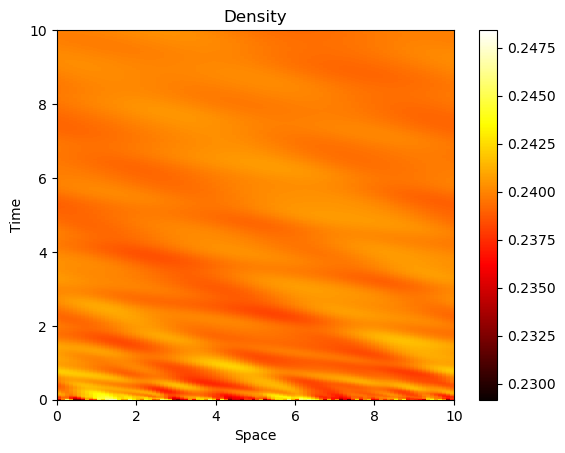

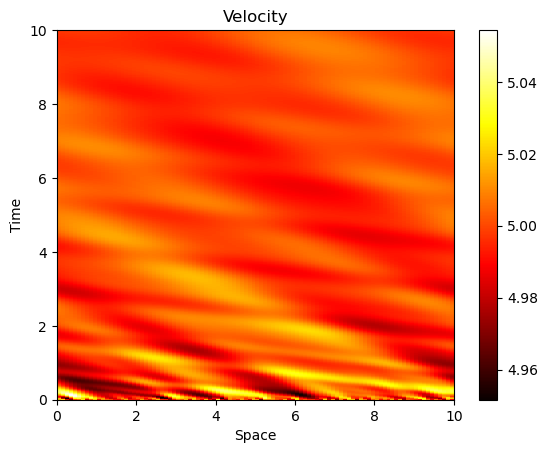

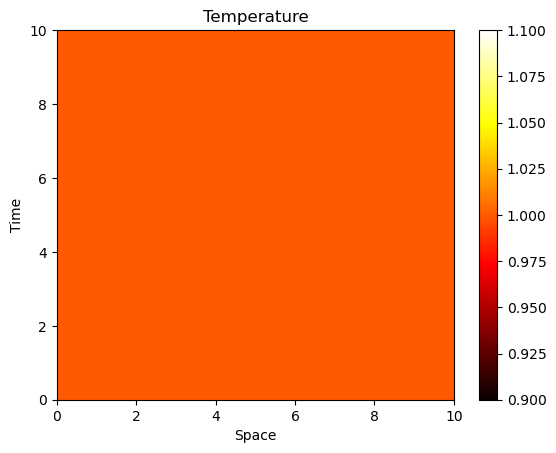

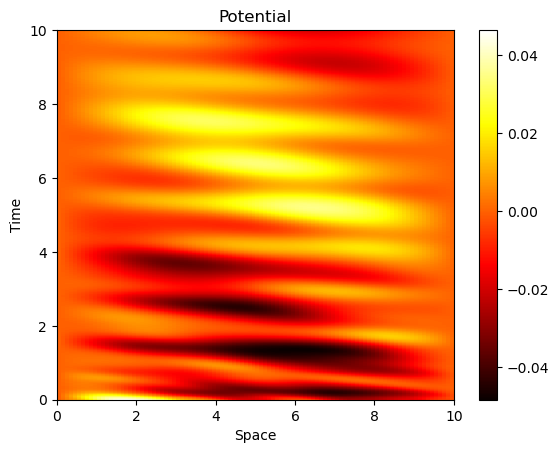

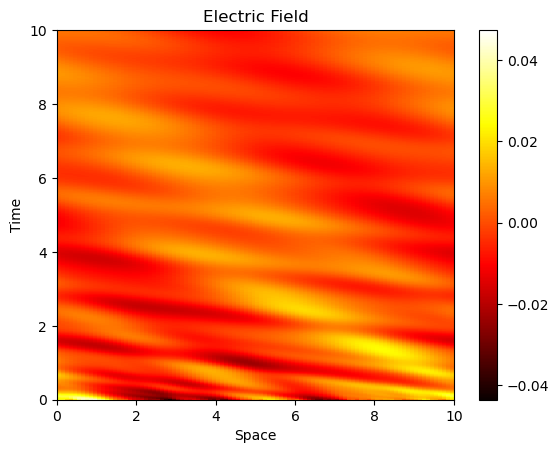

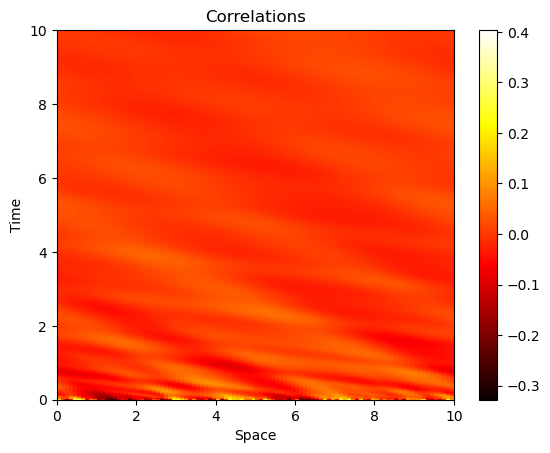

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

# Shift to Left
def l(array):
    return np.roll(array, 1, axis=-1)

# Shift to Right
def r(array):
    return np.roll(array, -1, axis=-1)

# Derivative
def ddx(array, dx):
    return (array - l(array)) / dx

# Second Derivative
def d2dx2(array, dx):
    return (r(array) - 2 * array + l(array)) / (dx * dx)

# Save Snap
def snapshot(fields, fieldConservations, n, u, T, Φ, C, cur_snap, dx, X):
    fields["Density"][cur_snap] = n
    fields["Velocity"][cur_snap] = u
    fields["Temperature"][cur_snap] = T
    fields["Potential"][cur_snap] = Φ
    fields["Electric Field"][cur_snap] = -ddx(Φ, dx)
    fields["Correlations"][cur_snap] = C

    fieldConservations["Density Integral"][cur_snap] = np.trapz(n, X)
    fieldConservations["Velocity Integral"][cur_snap] = np.trapz(u, X)
    fieldConservations["Temperature Integral"][cur_snap] = np.trapz(T, X)
    fieldConservations["Potential Sum"][cur_snap] = np.sum(Φ)
    fieldConservations["Electric Field Sum"][cur_snap] = np.sum(-ddx(Φ, dx))
    fieldConservations["Electric Field Integral"][cur_snap] = np.trapz(-ddx(Φ, dx), X)
    fieldConservations["Correlations Sum"][cur_snap] = np.sum(C)
    fieldConservations["Correlations Integral"][cur_snap] = np.trapz(C, X)

def sinusoidal(x, L, frequency, phase):
    return np.sin(2 * np.pi / L * frequency * (x + phase))

def gaussian(x, mean, std_dev):
    return np.exp(-((x - mean) ** 2 / (2 * std_dev ** 2)))

def constant(x, value):
    return np.full_like(x, value)

def random_noise(x, low, high):
    return np.random.uniform(low, high, size=x.shape)

def zero(x):
    return np.zeros_like(x)

def generate_initial_conditions(X, IC_field_params, IC_type, IC_amp, field_equil, roll_shift=0):
    """Generate initial conditions with random perturbations and shifts."""
    IC_func = globals()[IC_type]
    IC_values = IC_func(X, **IC_field_params[IC_type])
    IC = field_equil + IC_amp * IC_values
    IC = np.roll(IC, roll_shift)

    return IC

def solve_poisson(nx, n, dx):
    """
    Solves the Poisson equation with periodic boundary conditions using a special Thomas algorithm.
    """
    mean_n = np.mean(n)
    ρ = -4 * np.pi * (n - mean_n) * dx**2

    # Step 1: Compute potential at mesh point 0
    Φ = np.zeros(nx)
    Φ[0] = np.sum((np.arange(1, nx + 1) * ρ)) / nx

    # Step 2: Compute potential at mesh point 1
    Φ[1] = ρ[0] + 2 * Φ[0]

    # Step 3: Compute remaining potentials
    for i in range(2, nx):
        Φ[i] = ρ[i - 1] + 2 * Φ[i - 1] - Φ[i - 2]

    return Φ

def solve_correlations(n, L, dx, X, ext_factor, X_ext, κ, Γ, T):
    nx = len(X)
    C = np.zeros(nx)
    β = 1 / T

    # Tile domain on both sides to extend domain to capture long range effects
    n_ext = np.tile(n, 2 * ext_factor + 1)
    Γ_ext = np.tile(Γ, 2 * ext_factor + 1)
    κ_ext = np.tile(κ, 2 * ext_factor + 1)
    β_ext = np.tile(β, 2 * ext_factor + 1)

    # Meshgrid for extended domain interactions
    Xi_grid, Xj_grid = np.meshgrid(X, X_ext, indexing='ij')
    ni_grid, nj_grid = np.meshgrid(n, n_ext, indexing='ij')

    # plt.figure()
    # plt.plot(X_ext, n_ext)
    # plt.title('Extended Domain & Density')
    # plt.show()

    # Compute distances between points considering periodic boundary conditions
    distance = np.abs(Xi_grid - Xj_grid)
    # distance = np.minimum(distance, L - np.mod(distance, L))

    # Prevent division by zero in distance calculations
    distance[distance == 0] = 1e-16

    # plt.figure()
    # plt.imshow(distance, aspect='auto')
    # plt.colorbar()
    # plt.title('Distances')
    # plt.show()

    # Compute Coulomb potential
    u = 1 / distance

    # plt.figure()
    # plt.imshow(np.log(u), aspect='auto')
    # plt.colorbar()
    # plt.title('Log Potential')
    # plt.show()

    # Compute Parametrization factor A for the entire grid
    A = 1 + 1.5 * Γ_ext * np.exp(-κ_ext)

    # plt.figure()
    # plt.plot(A)
    # plt.title('Fitting Parameter')
    # plt.show()

    # Compute the direct correlation function across the extended domain
    dcf = A * (np.exp(-β_ext * u) / A - 1)

    # plt.figure()
    # plt.imshow(dcf, aspect='auto')
    # plt.colorbar()
    # plt.title('DCF')
    # plt.show()

    # Calculate the correlation interactions
    C = np.trapz(dcf * (ni_grid - nj_grid), x=X_ext, axis=1)

    # plt.figure()
    # plt.plot(C)
    # plt.title('Correlation')
    # plt.show()

    return C

def update_parameters(e, Q, n, T):
    a_i = (3 / (4 * np.pi * n))**(1/3)  # Ion Sphere Radius
    λ = np.sqrt(T / (4 * np.pi * e**2 * n))  # Debye Length

    mean_a_i = np.mean(a_i)
    mean_λ = np.mean(λ)
    mean_T = np.mean(T)

    # Calculate reference Γ and κ  # TODO: Fix such that Gamma0 and kappa0 are automatically found using means as inputs and, Gamma and kappa found if not means
    Γ0 = Q**2 / (mean_a_i * mean_T)
    κ0 = mean_a_i / mean_λ

    # Update Γ and κ as fields
    Γ = Γ0 * (mean_a_i * mean_T) / (a_i * T)
    κ = κ0 * (a_i * mean_λ) / (mean_a_i * λ)
    return a_i, λ, Γ, κ

# Spatial Domain
nx = int(1e2)
L = 10
dx = L / nx
X = np.linspace(0, L, nx, endpoint=False)
# Extended Spatial Domain
ext_factor = 5
X_ext = np.concatenate([X + i * L for i in range(-ext_factor, ext_factor + 1)])

# Temporal Domain
end_time = 10
t = 0
num_snaps = 1000
snap_interval = end_time / num_snaps
cur_snap = 0
Snaps = np.linspace(0, end_time, num_snaps + 1)

# Memory Allocation for Fields
fields = {
    "Density": np.empty((num_snaps+1, nx)),
    "Velocity": np.empty((num_snaps+1, nx)),
    "Temperature": np.empty((num_snaps+1, nx)),
    "Potential": np.empty((num_snaps+1, nx)),
    "Electric Field": np.empty((num_snaps+1, nx)),
    "Correlations": np.empty((num_snaps+1, nx))
}

# Conservation checks
fieldConservations = {
    "Density Integral": np.empty(num_snaps+1),
    "Velocity Integral": np.empty(num_snaps+1),
    "Temperature Integral": np.empty(num_snaps+1), 
    "Potential Sum": np.empty(num_snaps+1),
    "Electric Field Sum": np.empty(num_snaps+1), 
    "Electric Field Integral": np.empty(num_snaps+1),
    "Correlations Sum": np.empty(num_snaps+1),
    "Correlations Integral": np.empty(num_snaps+1)
}

# Constants
cfl_safety = 0.1
e = 1.0  # Assuming unit charge
Q = 1.0  # Assuming unit charge
therm_cond = 0.1  # Thermal Conductivity, Technically Thermal Diffusivity After Nondimensionalization

mean_n = 3 / (4*np.pi) * np.ones_like(X)
mean_u = 5 * np.ones_like(X)
mean_T = 1 * np.ones_like(X)
a_i, λ, Γ, κ = update_parameters(e, Q, mean_n, mean_T)  # Initialize Parameters with Mean Field Values

# Initial Conditions
IC_amp = 0.1 * np.array([1, 1, 1])
IC_field_params = {
    'sinusoidal': {'L': L, 'frequency': 3, 'phase': 0},  # Frequency and Phase in terms of domain
    'gaussian': {'mean': np.mean(X), 'std_dev': 1},      
    'constant': {'value': 0.5},                          # Adds constant offset as value before multiplication by pertubation amplitude
    'random_noise': {'low': -0.1, 'high': 0.1},          # Adds random noise between low and high values before multiplication by pertubation amplitude
    'zero': {}
}

n = generate_initial_conditions(X, IC_field_params, 'random_noise', IC_amp[0], mean_n, roll_shift=0)
u = generate_initial_conditions(X, IC_field_params, 'zero', IC_amp[1], mean_u, roll_shift=0)
T = generate_initial_conditions(X, IC_field_params, 'zero', IC_amp[2], mean_T, roll_shift=0)
Φ = solve_poisson(nx, n, dx)
C = solve_correlations(n, L, dx, X, ext_factor, X_ext, κ, Γ, T)

# Save Initial Snapshot
snapshot(fields, fieldConservations, n, u, T, Φ, C, cur_snap, dx, X)
cur_snap += 1

# Time Integration
while t < end_time:
    # Calculate dt and next snapshot time
    max_field_speed = np.max(np.array([np.abs(u).max()]))
    dt = cfl_safety * dx / max_field_speed

    next_snap_time = cur_snap * snap_interval
    if t + dt >= next_snap_time:
        dt = next_snap_time - t  # Adjust dt to exactly reach the snapshot time

    # Update fields
    a_i, λ, Γ, κ = update_parameters(e, Q, n, T)
    Φ = solve_poisson(nx, n, dx)  # Solve Poisson Equation
    C = solve_correlations(n, L, dx, X, ext_factor, X_ext, κ, Γ, T)  # Solve Correlations Equation
    n -= dt * ddx(n * u, dx)
    u -= dt * ( u * ddx(u, dx) - T * ddx(n, dx) / n + Γ * T * ddx(Φ, dx) - ddx(C, dx) )  # Subtract Correlations Term: -ddx(C) in the parenthesis
    T -= dt * ( u * ddx(T, dx) - d2dx2(therm_cond * T, dx) )

    # Time update
    t += dt

    if t >= next_snap_time:
        snapshot(fields, fieldConservations, n, u, T, Φ, C, cur_snap, dx, X)
        cur_snap += 1

# Plotting
# for fieldName, fieldValues in fields.items():
#     plt.figure()
#     for snap in fieldValues:
#         plt.plot(X, snap)
#     plt.title(fieldName)
#     plt.show()

# Heat Map
for fieldName, fieldValues in fields.items():
    plt.figure()
    plt.imshow(np.flip(fieldValues), cmap='hot', extent=[0, L, 0, end_time], interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.title(fieldName)
    plt.ylim()
    plt.ylabel("Time")
    plt.xlabel("Space")
    plt.show()

# TODO: Fix derivative calculation
# TODO: Correlation domain extension
# TODO: Types of analysis? DMD, Wavelet, FFT, etc.?

We start with the perturbations for the variables:
\begin{align}
    n = n_0 + \delta n, \quad \mathbf{u} = \mathbf{u}_0 + \delta \mathbf{u}, \quad T = T_0 + \delta T, \quad \Phi = \Phi_0 + \delta \Phi, \quad C = C_0 + \delta C
\end{align}

The linearized system of equations becomes:

\begin{align}
    \sigma \delta n + n_0 i \mathbf{k} \cdot \delta \mathbf{u} + \delta n i \mathbf{k} \cdot \mathbf{u}_0 &= 0, \\
    \sigma \delta \mathbf{u} + \mathbf{u}_0 i \mathbf{k} \cdot \delta \mathbf{u} &= - i \mathbf{k} \frac{T_0}{n_0} \delta n + \Gamma T_0 i \mathbf{k} \delta \Phi - i \mathbf{k} \delta C, \\
    \sigma \delta T + \mathbf{k} \cdot \mathbf{u}_0 i \delta T &= - \lambda |\mathbf{k}|^2 \delta T, \\
    - \frac{|\mathbf{k}|^2}{4 \pi} \delta \Phi &= \delta n.
\end{align}

Now, by combining the Poisson equation with the momentum equation and separating the temperature from the other equations, we get:

\begin{align}
    \sigma \delta n + n_0 i \mathbf{k} \cdot \delta \mathbf{u} + \delta n i \mathbf{k} \cdot \mathbf{u}_0 &= 0, \\
    \sigma \delta \mathbf{u} + \mathbf{u}_0 i \mathbf{k} \cdot  \delta \mathbf{u} &= - i \mathbf{k} \frac{T_0}{n_0} \delta n + \Gamma T_0 i \mathbf{k} \left(- \frac{4 \pi}{|\mathbf{k}|^2} \delta n \right) - i \mathbf{k} \delta C \\
    &= - i \mathbf{k} \left(\frac{T_0}{n_0} \delta n + \frac{4 \pi \Gamma T_0}{|\mathbf{k}|^2} \delta n + \delta C\right), \\
    \sigma(\mathbf{k}) &= - \mathbf{u}_0 i \mathbf{k}  - \lambda |\mathbf{k}|^2.
\end{align}

Now, organizing the remaining terms:

\begin{align}
    (\sigma + i \mathbf{k} \cdot \mathbf{u}_0) \delta n + n_0 i \mathbf{k} \cdot \delta \mathbf{u} &= 0, \\
    (\sigma + \mathbf{u}_0 i \mathbf{k}) \delta \mathbf{u} + \left( i \mathbf{k} \frac{T_0}{n_0} + \Gamma T_0 i \mathbf{k} \frac{4 \pi}{|\mathbf{k}|^2} \right) \delta n &= - i \mathbf{k} \delta C.
\end{align}

### Matrix Representation:

The system of equations can now be written in matrix form as:

\begin{align}
    \begin{pmatrix}
    \sigma + i \mathbf{k} \cdot \mathbf{u}_0 & n_0 i \mathbf{k} \\
    i \mathbf{k} \left( \frac{T_0}{n_0} + \frac{4 \pi \Gamma T_0}{|\mathbf{k}|^2} \right) & \sigma + i \mathbf{k} \cdot \mathbf{u}_0
    \end{pmatrix}
    \begin{pmatrix}
    \delta n \\
    \delta \mathbf{u}
    \end{pmatrix}
    =
    \begin{pmatrix}
    0 \\
    0
    \end{pmatrix}
\end{align}

### Dispersion Relation:

For nontrivial solutions, we set the determinant of the matrix to zero, yielding the dispersion relation:

\begin{align}
    (\sigma + i \mathbf{k} \cdot \mathbf{u}_0)^2 + n_0 |\mathbf{k}|^2 \left( \frac{T_0}{n_0} + \frac{4 \pi \Gamma T_0}{|\mathbf{k}|^2} \right) &= 0 \\
    (\sigma + i \mathbf{k} \cdot \mathbf{u}_0)^2 + |\mathbf{k}|^2 T_0 + 4 \pi \Gamma T_0 n_0 &= 0 \\
    \sigma(\mathbf{k}) &= -i \mathbf{k} \cdot \mathbf{u}_0 \pm i \sqrt{|\mathbf{k}|^2 T_0 + 4 \pi \Gamma T_0 n_0}.
\end{align}

In terms of \( \omega \) (where \( \sigma = i \omega \)):

\begin{align}
    \omega(\mathbf{k}) &= - |\mathbf{k}| \left( \mathbf{u}_0 \pm \sqrt{T_0 + 4 \pi \Gamma T_0 n_0 \frac{1}{|\mathbf{k}|^2}} \right).
\end{align}

For the specific case where $n_0 = \frac{3}{4 \pi}$, $\mathbf{u}_0 = 5$, and $T_0 = 1$, the dispersion relation simplifies to:

\begin{align}
    \omega(\mathbf{k}) &= - |\mathbf{k}| \left( 5 \pm \sqrt{1 + 3 \frac{\Gamma}{|\mathbf{k}|^2}} \right).
\end{align}

In [182]:
np.savetxt('density_data.csv', fields['Density'], delimiter=',')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


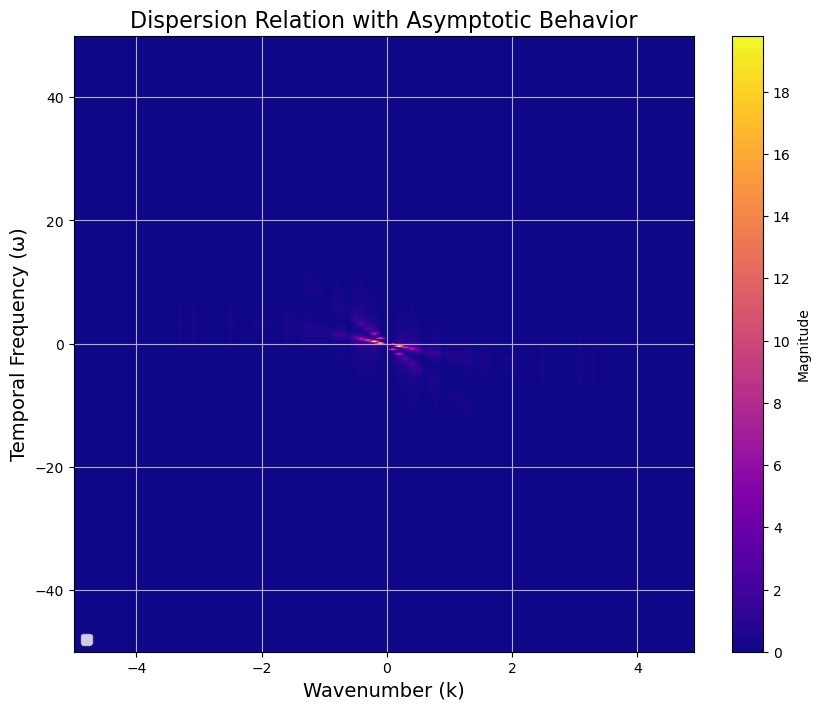

In [208]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have `fields['Density']` data from the simulation
density = fields['Density']

# Center the density data by subtracting the mean
# centered_density = density - np.mean(density, axis=1, keepdims=True)
centered_density = density - np.mean(density)

# Compute spatial and temporal frequencies
kx = np.fft.fftfreq(nx, d=dx)
kt = np.fft.fftfreq(num_snaps + 1, d=snap_interval)
kx_shifted = np.fft.fftshift(kx)  # Shift zero frequency to center
kt_shifted = np.fft.fftshift(kt)  # Shift zero frequency to center

KX, KT = np.meshgrid(kx_shifted, kt_shifted)

# Perform 2D FFT on the centered density data
density_fft2 = np.fft.fft2(centered_density)
density_fft2_shifted = np.fft.fftshift(density_fft2)
magnitude_spectrum = np.abs(density_fft2_shifted)

# Add the theoretical dispersion relation curve
n0 = mean_n
u0 = mean_u
T0 = mean_T
Γ0 = np.mean(Γ)

# Theoretical dispersion relation: Use k from the spatial frequencies
def σ(n0, u0, T0, k, Γ0):
    σ_plus = 1j * (-k * u0 + np.sqrt(k ** 2 * T0 + 4 * np.pi * Γ0 * T0 * n0))
    σ_minus = 1j * (-k * u0 - np.sqrt(k ** 2 * T0 + 4 * np.pi * Γ0 * T0 * n0))
    return σ_plus, σ_minus

σ_plus, σ_minus = σ(n0, u0, T0, kx_shifted, Γ0)

# Compute the real frequency (ω) for both branches of the dispersion relation
ω_plus_theory = np.imag(σ_plus)
ω_minus_theory = np.imag(σ_minus)

# Asymptotic lines for k -> infinity: Slope approaches u0 ± sqrt(T0)
asymptote_high_k_plus = kx_shifted * (-u0 + np.sqrt(T0))
asymptote_high_k_minus = kx_shifted * (-u0 - np.sqrt(T0))

# Asymptotic behavior for k -> 0: Approaches ±sqrt(4 pi Gamma T0 n0)
asymptote_low_k_plus = np.sqrt(4 * np.pi * Γ0 * T0 * n0)
asymptote_low_k_minus = -np.sqrt(4 * np.pi * Γ0 * T0 * n0)

# Plotting the results
# Perform 2D FFT on the centered density data
plt.figure(figsize=(10, 8))
plt.contourf(KX, KT, magnitude_spectrum, levels=100, cmap='plasma')
plt.colorbar(label='Magnitude')
plt.title('2D FFT of Centered Density Field With Dispersion Relation & Asymptotic Behavior', fontsize=16)
plt.xlabel('Wavenumber (k)', fontsize=14)
plt.ylabel('Temporal Frequency (ω)', fontsize=14)

# Plot the theoretical dispersion relation on top of the 2D FFT result
# plt.plot(kx_shifted, ω_plus_theory, 'r', label=r'$\omega_+$ (Theoretical)')
# plt.plot(kx_shifted, ω_minus_theory, 'b', label=r'$\omega_-$ (Theoretical)')

# Plot asymptotes
# plt.plot(kx_shifted, asymptote_high_k_plus, 'r--', label=r'Asymptote $-u_0 + \sqrt{T_0}$ for $k \to \infty$')
# plt.plot(kx_shifted, asymptote_high_k_minus, 'b--', label=r'Asymptote $-u_0 - \sqrt{T_0}$ for $k \to \infty$')
# plt.plot(0, np.sqrt(4 * np.pi * Γ0 * T0 * n0), marker="x", markersize=5, label=r'$\sqrt{4 \pi \Gamma T_0 n_0}$ for $k \to 0$')
# plt.plot(0, -np.sqrt(4 * np.pi * Γ0 * T0 * n0), marker="x", markersize=5, label=r'$-\sqrt{4 \pi \Gamma T_0 n_0}$ for $k \to 0$')

# Set axis limits for clarity
plt.xlim([min(kx_shifted), max(kx_shifted)])
plt.ylim([min(kt_shifted), max(kt_shifted)])

# Show plot with expected frequencies
plt.title("Dispersion Relation with Asymptotic Behavior", fontsize=16)
plt.grid(True)
plt.legend(loc='lower left', fontsize=10)
plt.show()

# Check Dispersion Relation With Sinusoidal Waves

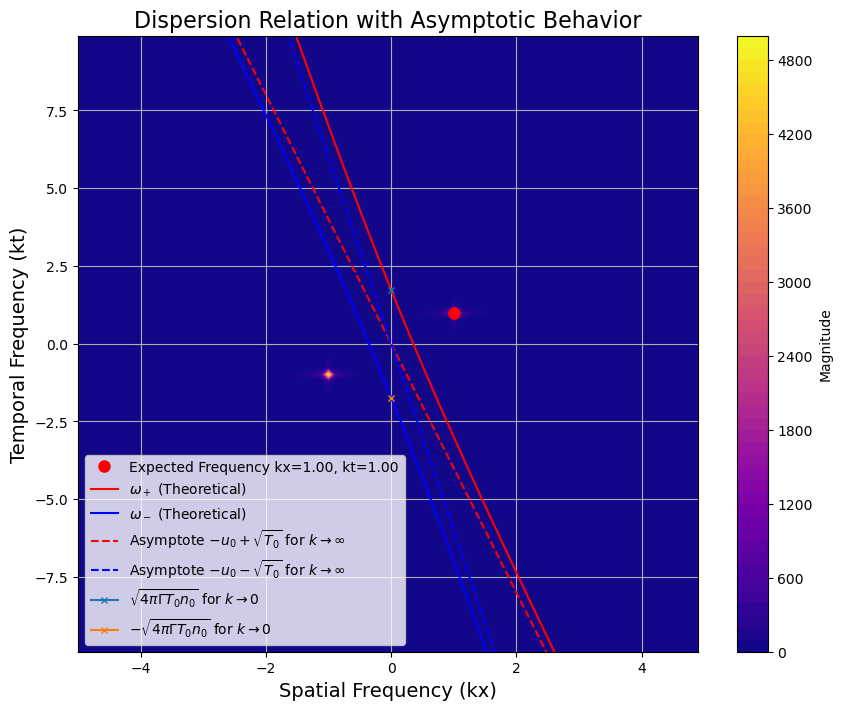

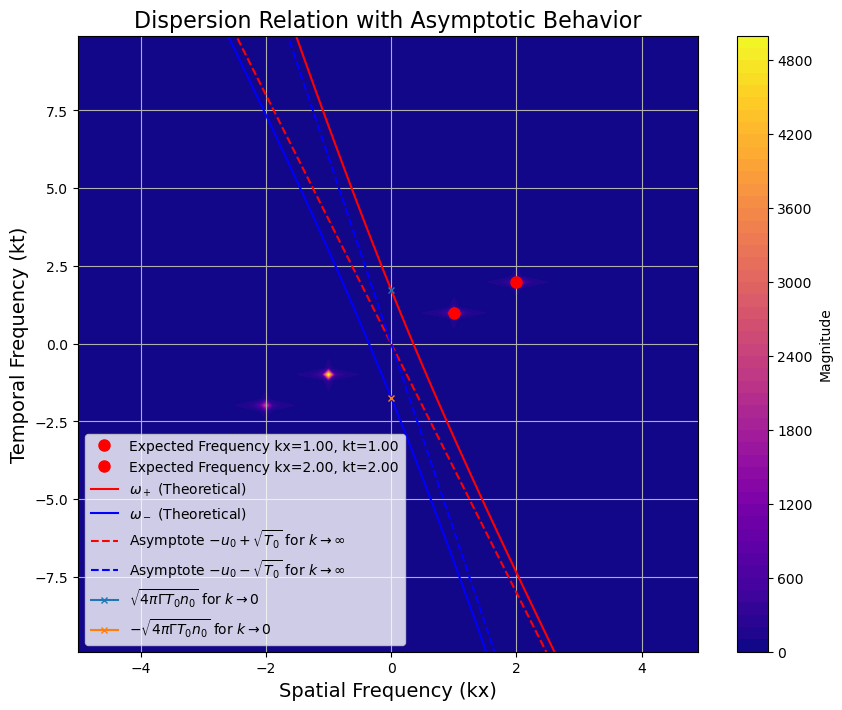

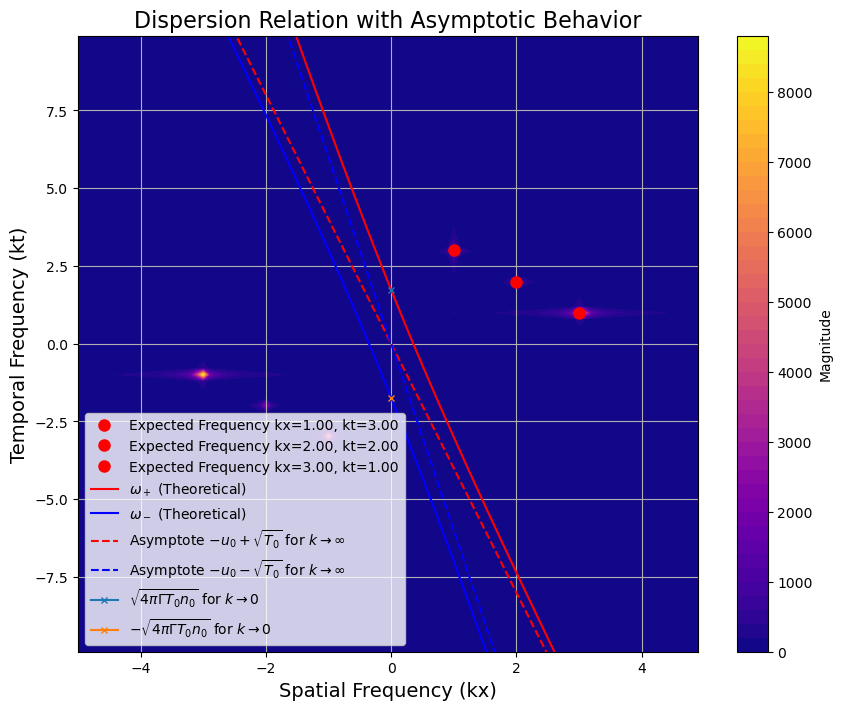

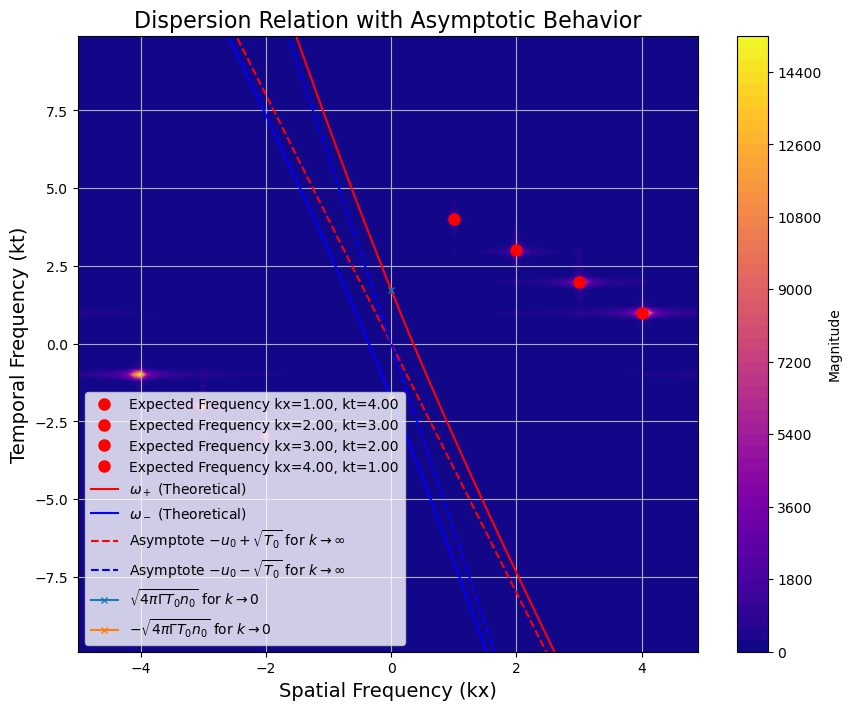

In [142]:
import numpy as np
import matplotlib.pyplot as plt

# Example setup for FFT and expected frequencies
L = 10  # Length of the spatial domain
end_time = 5  # Total time
nx = 100  # Number of spatial points
num_snaps = 100  # Number of time snapshots
dx = L / nx  # Spatial step
snap_interval = end_time / num_snaps  # Time interval between snapshots

# Compute spatial and temporal frequencies
kx = np.fft.fftfreq(nx, d=dx)
kt = np.fft.fftfreq(num_snaps + 1, d=snap_interval)
kx_shifted = np.fft.fftshift(kx)  # Shift zero frequency to center
kt_shifted = np.fft.fftshift(kt)  # Shift zero frequency to center

KX, KT = np.meshgrid(kx_shifted, kt_shifted)

# Define Parameters
def wave(f_x, f_t, amp, X_grid, Y_grid):
    """Generate a wave pattern based on spatial frequency f_x and temporal frequency f_t."""
    return amp * np.sin(2 * np.pi * (f_x * X_grid + f_t * Y_grid))

def generate_density_field(frequencies_x, frequencies_t, amplitudes, X_grid, Y_grid):
    """Generate a density field with multiple waves using frequencies instead of wavelengths."""
    density = np.zeros_like(X_grid)
    for f_x, f_t, amp in zip(frequencies_x, frequencies_t, amplitudes):
        density += wave(f_x, f_t, amp, X_grid, Y_grid)
    return density

# Create grid for space (X) and time (Y)
X_grid, Y_grid = np.meshgrid(np.linspace(0, L, nx), np.linspace(0, end_time, num_snaps + 1))

# Example 1: Single sinusoidal wave
frequencies_x_1 = np.array([1])  # Spatial frequencies
frequencies_t_1 = np.array([1])  # Temporal frequencies
amplitudes_1 = [1]
density_1 = generate_density_field(frequencies_x_1, frequencies_t_1, amplitudes_1, X_grid, Y_grid)

# Example 2: Two waves at different frequencies
frequencies_x_2 = np.array([1, 2])
frequencies_t_2 = np.array([1, 2])
amplitudes_2 = [1, 0.5]
density_2 = generate_density_field(frequencies_x_2, frequencies_t_2, amplitudes_2, X_grid, Y_grid)

# Example 3: Three waves with varying frequencies
frequencies_x_3 = np.array([1, 2, 3])
frequencies_t_3 = np.array([3, 2, 1])
amplitudes_3 = [1, 0.5, 2]
density_3 = generate_density_field(frequencies_x_3, frequencies_t_3, amplitudes_3, X_grid, Y_grid)

# Example 4: Four complex waves
frequencies_x_4 = np.array([1, 2, 3, 4])
frequencies_t_4 = np.array([4, 3, 2, 1])
amplitudes_4 = [1, 2, 3, 4]
density_4 = generate_density_field(frequencies_x_4, frequencies_t_4, amplitudes_4, X_grid, Y_grid)

# List of densities and their associated frequencies
all_frequencies_x = [frequencies_x_1, frequencies_x_2, frequencies_x_3, frequencies_x_4]
all_frequencies_t = [frequencies_t_1, frequencies_t_2, frequencies_t_3, frequencies_t_4]
all_amplitudes = [amplitudes_1, amplitudes_2, amplitudes_3, amplitudes_4]
densities = [density_1, density_2, density_3, density_4]

# Add the theoretical dispersion relation curve
n0 = 3 / (4 * np.pi)
u0 = 5
T0 = 1
Γ0 = 1

# Theoretical dispersion relation: Use k from the spatial frequencies
σ_plus = lambda n0, u0, T0, k, Γ0: 1j * (-k * u0 + np.sqrt(k**2 * T0 + 4 * np.pi * Γ0 * T0 * n0))
σ_minus = lambda n0, u0, T0, k, Γ0: 1j * (-k * u0 - np.sqrt(k**2 * T0 + 4 * np.pi * Γ0 * T0 * n0))

# Compute the real frequency (ω) for both branches of the dispersion relation
ω_plus_theory = np.imag(σ_plus(n0, u0, T0, kx_shifted, Γ0))
ω_minus_theory = np.imag(σ_minus(n0, u0, T0, kx_shifted, Γ0))

# Asymptotic lines for k -> infinity: Slope approaches u0 ± sqrt(T0)
asymptote_high_k_plus = kx_shifted * (-u0 + np.sqrt(T0))
asymptote_high_k_minus = kx_shifted * (-u0 - np.sqrt(T0))

# Asymptotic behavior for k -> 0: Approaches ±sqrt(4 pi Gamma T0 n0)
asymptote_low_k_plus = np.sqrt(4 * np.pi * Γ0 * T0 * n0)
asymptote_low_k_minus = -np.sqrt(4 * np.pi * Γ0 * T0 * n0)

# Plotting the results
for density, frequencies_x, frequencies_t, amplitudes in zip(densities, all_frequencies_x, all_frequencies_t, all_amplitudes):
    # Compute expected spatial and temporal frequencies
    expected_frequencies_x = frequencies_x
    expected_frequencies_t = frequencies_t

    # Perform 2D FFT on the density data
    density_fft2 = np.fft.fft2(density)
    density_fft2_shifted = np.fft.fftshift(density_fft2)
    magnitude_spectrum = np.abs(density_fft2_shifted)

    # Plot 2D FFT result
    plt.figure(figsize=(10, 8))
    plt.contourf(KX, KT, magnitude_spectrum, levels=50, cmap='plasma')
    plt.colorbar(label='Magnitude')
    plt.title('2D FFT of Density Field With Dispersion Relation & Asymptotic Behavior', fontsize=16)
    plt.xlabel('Spatial Frequency (kx)', fontsize=14)
    plt.ylabel('Temporal Frequency (kt)', fontsize=14)

    # Plot the expected frequencies as points on top of the FFT plot
    for kx_exp, kt_exp in zip(expected_frequencies_x, expected_frequencies_t):
        plt.plot(kx_exp, kt_exp, 'ro', markersize=8, label=f"Expected Frequency kx={kx_exp:.2f}, kt={kt_exp:.2f}")

    # Plot the theoretical dispersion relation on top of the 2D FFT result
    plt.plot(kx_shifted, ω_plus_theory, 'r', label=r'$\omega_+$ (Theoretical)')
    plt.plot(kx_shifted, ω_minus_theory, 'b', label=r'$\omega_-$ (Theoretical)')

    # Plot asymptotes
    plt.plot(kx_shifted, asymptote_high_k_plus, 'r--', label=r'Asymptote $-u_0 + \sqrt{T_0}$ for $k \to \infty$')
    plt.plot(kx_shifted, asymptote_high_k_minus, 'b--', label=r'Asymptote $-u_0 - \sqrt{T_0}$ for $k \to \infty$')
    plt.plot(0, np.sqrt(4 * np.pi * Γ0 * T0 * n0), marker="x", markersize=5, label=r'$\sqrt{4 \pi \Gamma T_0 n_0}$ for $k \to 0$')
    plt.plot(0, -np.sqrt(4 * np.pi * Γ0 * T0 * n0), marker="x", markersize=5, label=r'$-\sqrt{4 \pi \Gamma T_0 n_0}$ for $k \to 0$')

    # Set ticks on y-axis to include the value of √(4 π Γ T0 n0)
    # y_ticks = plt.gca().get_yticks()
    # new_y_ticks = np.append(y_ticks, [asymptote_low_k_plus, asymptote_low_k_minus])
    # plt.yticks(new_y_ticks)  # Add the specific tick at ± √(4 π Γ T0 n0)

    # Set axis limits for clarity
    plt.xlim([min(kx_shifted), max(kx_shifted)])
    plt.ylim([min(kt_shifted), max(kt_shifted)])

    # Show plot with expected frequencies
    plt.title("Dispersion Relation with Asymptotic Behavior", fontsize=16)
    plt.grid(True)
    plt.legend(loc='lower left', fontsize=10)
    plt.show()

/var/folders/mj/vl8lzxz54kq5ykc7s_pzj2980000gn/T/ipykernel_7726/850769537.py:14: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([np.min(field_data), np.max(field_data)])


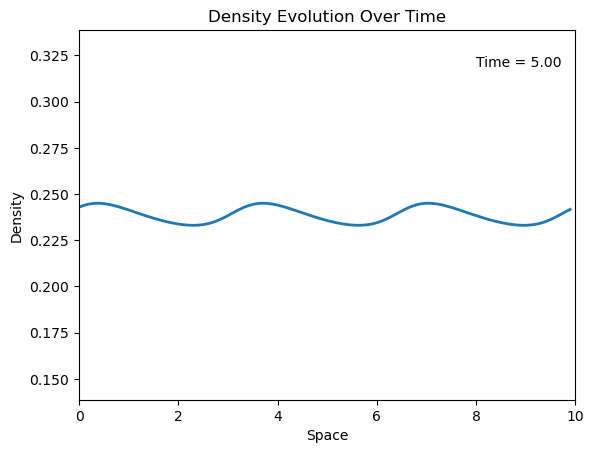

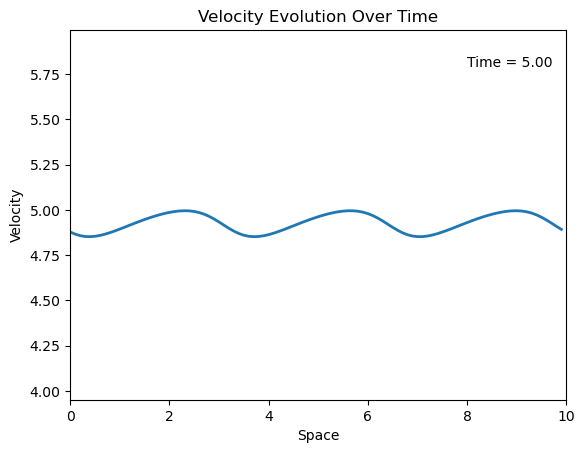

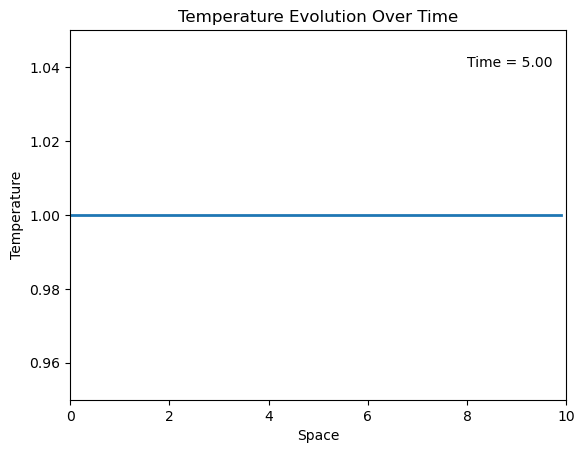

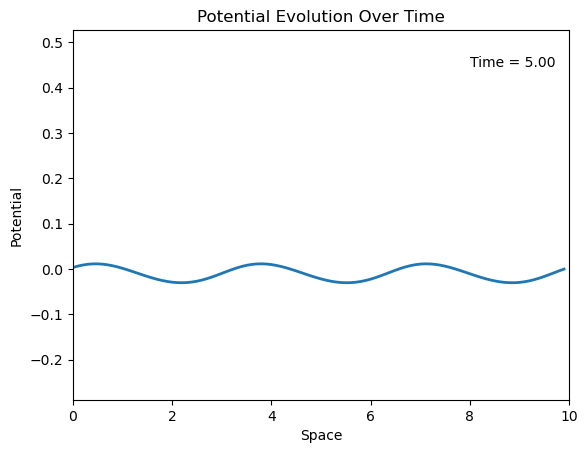

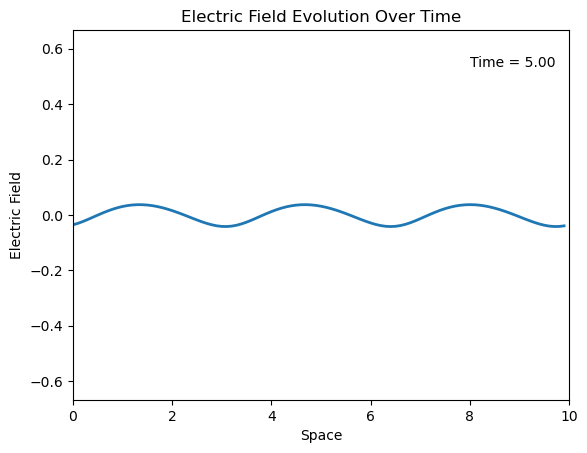

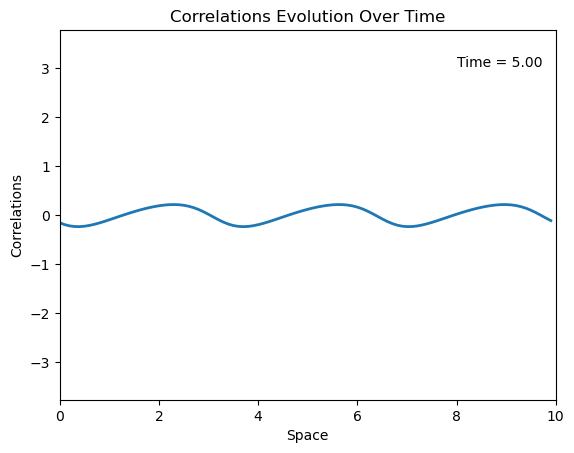

In [29]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import os

def save_animation_as_mp4(fields, X, L, end_time, num_snaps, field_name="Density"):
    """
    Save animation as an MP4 file.
    """
    field_data = fields[field_name]

    fig, ax = plt.subplots()
    ax.set_xlim([0, L])
    ax.set_ylim([np.min(field_data), np.max(field_data)])
    ax.set_xlabel('Space')
    ax.set_ylabel(field_name)
    ax.set_title(f"{field_name} Evolution Over Time")

    line, = ax.plot([], [], lw=2)
    time_text = ax.text(0.8, 0.9, '', transform=ax.transAxes)

    def init():
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text

    def update(frame):
        line.set_data(X, field_data[frame])
        time_text.set_text(f'Time = {frame * end_time / num_snaps:.2f}')
        return line, time_text

    ani = FuncAnimation(fig, update, frames=num_snaps + 1, init_func=init, blit=True, interval=100)

    # Save the animation as an MP4 file using Pillow
    output_dir = 'Animations'
    filename = field_name + '_animation.gif'
    full_path = os.path.join(output_dir, filename)
    ani.save(full_path, writer="pillow")

# Animate Fields
for fieldName in fields.keys():
    save_animation_as_mp4(fields, X, L, end_time, num_snaps, field_name=fieldName)

# # Animate the "Density" field
# save_animation_as_mp4(fields, X, L, end_time, num_snaps, field_name="Density")

# # Animate the "Velocity" field
# save_animation_as_mp4(fields, X, L, end_time, num_snaps, field_name="Velocity")

# # Animate the "Temperature" field
# save_animation_as_mp4(fields, X, L, end_time, num_snaps, field_name="Temperature")

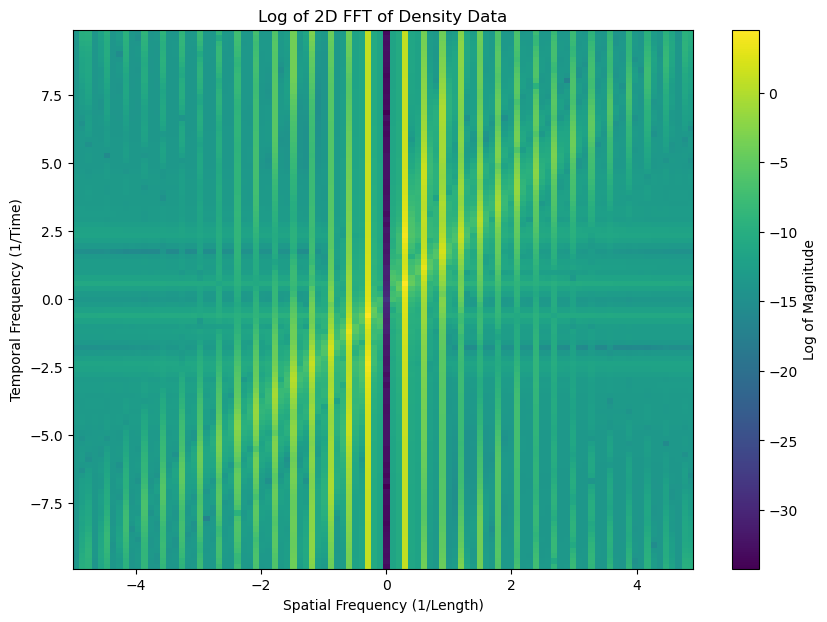

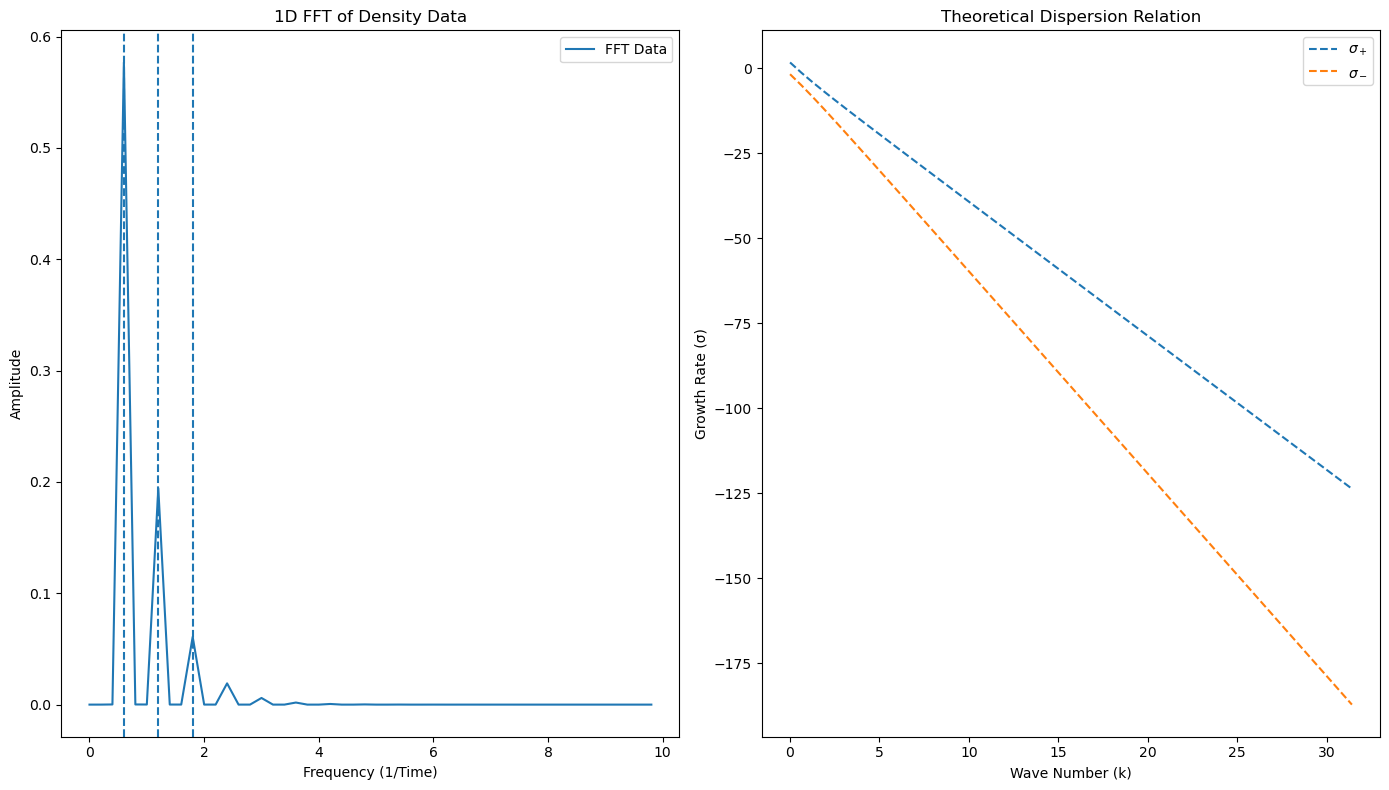

0.6000000000000001


In [245]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.fftpack import fftfreq, ifft2

## 2D FFT

# Centralize Density Data
density = fields['Density']
centralized_density = density - mean_n
# centralized_density = detrend(centralized_density, axis=1, type='linear')
# centralized_density = detrend(centralized_density, axis=0, type='linear')

# Perform 2D FFT
fft2D_result = np.fft.fft2(centralized_density)
fft2D_shifted = np.fft.fftshift(fft2D_result)  # Shift zero frequency components to the center of the spectrum
magnitude_spectrum = np.abs(fft2D_shifted)

# Frequencies for each dimension
frequencies_time = np.fft.fftfreq(density.shape[0], d=snap_interval)
frequencies_space = np.fft.fftfreq(density.shape[1], d=dx)
freq_x, freq_t = np.meshgrid(frequencies_space, frequencies_time)

# Plot the 2D FFT result
plt.figure(figsize=(10, 7))
plt.imshow(np.log(magnitude_spectrum), extent=(frequencies_space.min(), frequencies_space.max(), frequencies_time.min(), frequencies_time.max()), aspect='auto')
plt.colorbar(label='Log of Magnitude')
plt.title('Log of 2D FFT of Density Data')
plt.xlabel('Spatial Frequency (1/Length)')
plt.ylabel('Temporal Frequency (1/Time)')

# Optionally, overlay the theoretical dispersion curves
# Note: This requires conversion of theoretical values to match the FFT output, can be complex depending on the data layout
plt.show()

## Analytical Dispersion Relation

k = 2 * np.pi / L * np.arange(0, nx//2 + 1)
mean_u = np.mean(fields['Velocity'])
mean_T = np.mean(fields['Temperature'])
mean_Γ = np.mean(Γ)

# Analytical dispersion relation
σ_plus = lambda k: -1j * k * mean_u + 1j * np.sqrt(mean_T * (k**2 + 3 * mean_Γ))
σ_minus = lambda k: -1j * k * mean_u - 1j * np.sqrt(mean_T * (k**2 + 3 * mean_Γ))

σ_plus_vals = σ_plus(k)
σ_minus_vals = σ_minus(k)

## 1D FFT

# Choose a spatial point to analyze in 1D FFT
point_idx = nx // 2
density_point_analysis = centralized_density[point_idx]

# Perform FFT on the time series of the selected/averaged point
fft1D_result = np.fft.fft(density_point_analysis)
frequencies = np.fft.fftfreq(len(density_point_analysis), d=(snap_interval))  # Time between snapshots as the sampling interval

# expected_freq = 2 * np.pi / L * IC_field_params['sinusoidal']['frequency']
# converted_expected_freq = 2 * expected_freq / (2 * np.pi)

expected_freq = 2 * IC_field_params['sinusoidal']['frequency'] / L

# Plot 1D FFT Results
plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)
plt.title("1D FFT of Density Data")
plt.plot(frequencies[:nx//2], np.abs(fft1D_result[:nx//2]), label="FFT Data")  # Positive Frequencies
plt.axvline(expected_freq, linestyle='--')
plt.axvline(2 * expected_freq, linestyle='--')
plt.axvline(3 * expected_freq, linestyle='--')
# plt.xscale('log')
plt.xlabel("Frequency (1/Time)")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Theoretical Dispersion Relation")
plt.plot(k, np.imag(σ_plus_vals), label="$\sigma_+$", linestyle='--')
plt.plot(k, np.imag(σ_minus_vals), label="$\sigma_-$", linestyle='--')
plt.xlabel("Wave Number (k)")
plt.ylabel("Growth Rate (σ)")
plt.legend()

plt.tight_layout()
plt.show()



print(frequencies[:nx//2][np.argmax(np.abs(fft1D_result[:nx//2]))])



In [226]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.fftpack import fftfreq, ifft2

# Detrend the density data
centralized_density_detrended = detrend(centralized_density, axis=1, type='linear')
centralized_density_detrended = detrend(centralized_density_detrended, axis=0, type='linear')

# Perform 2D FFT
fft_density = np.fft.fft2(centralized_density_detrended)

# Apply a high-pass filter to remove low-frequency components
freq_x = fftfreq(centralized_density.shape[1], dx)
freq_t = fftfreq(centralized_density.shape[0], snap_interval)
high_pass_threshold = 0.1  # Adjust this value
filter_mask = np.abs(freq_x) > high_pass_threshold
fft_density_filtered = fft_density * filter_mask[:, np.newaxis]

# Inverse FFT to return to space-time domain after filtering
filtered_density = np.real(ifft2(fft_density_filtered))

# Perform the 2D FFT again on the filtered data
fft_density_filtered = np.fft.fft2(filtered_density)
fft_density_shifted = np.fft.fftshift(fft_density_filtered)

# Extract non-negative frequencies
nn_indices_x = np.where(freq_x >= 0)  # Non-negative spatial frequencies
nn_indices_t = np.where(freq_t >= 0)  # Non-negative temporal frequencies
nn_fft_density = fft_density_shifted[np.ix_(nn_indices_t[0], nn_indices_x[0])]
nnkx = freq_x[nn_indices_x]  # Non-negative kx
nnkt = freq_t[nn_indices_t]  # Non-negative kt

# Calculate power spectral density
psd_normalized = np.abs(nn_fft_density) ** 2 / np.max(np.abs(nn_fft_density) ** 2)

# Plot the results
extent = [nnkx.min(), nnkx.max(), nnkt.min(), nnkt.max()]
plt.imshow(np.log(psd_normalized + 1e-10), aspect='auto', extent=extent, origin='lower', cmap='plasma')
plt.xlabel('Spatial Frequency (kx)')
plt.ylabel('Temporal Frequency (ω)')
plt.title('Log of 2D FFT of Density Data (Filtered)')
plt.colorbar(label='Log of Magnitude')
plt.show()


ValueError: operands could not be broadcast together with shapes (1001,200) (200,1) 

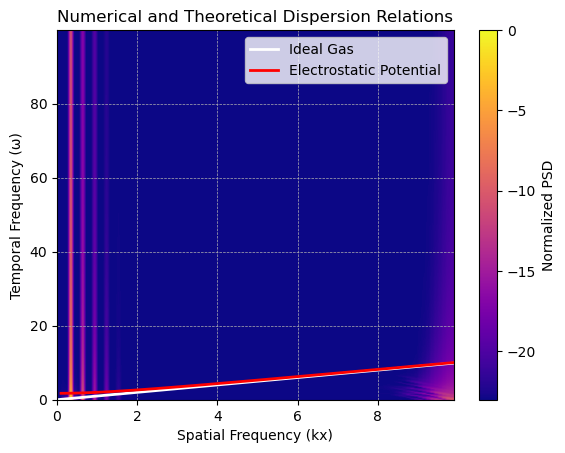

In [232]:
import numpy as np
import matplotlib.pyplot as plt

# Use your current simulation parameters and data
kx = np.fft.fftfreq(centralized_density.shape[1], dx)  # Spatial frequency
kt = np.fft.fftfreq(centralized_density.shape[0], d=snap_interval)  # Temporal frequency

# Shift the zero frequency components to the center
kx_shifted = np.fft.fftshift(kx)
kt_shifted = np.fft.fftshift(kt)

# Compute the 2D FFT of the centralized density data and shift the FFT
centralized_density_fft = np.fft.fft2(centralized_density)
centralized_density_fft_shifted = np.fft.fftshift(centralized_density_fft)

# Compute non-negative indices for space and time frequencies
nn_indices_x = np.where(kx_shifted >= 0)
nn_indices_t = np.where(kt_shifted >= 0)

# Extract non-negative frequency parts
nn_fft_density = centralized_density_fft_shifted[np.ix_(nn_indices_t[0], nn_indices_x[0])]
nnkx = kx_shifted[nn_indices_x]
nnkt = kt_shifted[nn_indices_t]

# Get positive kx and kt for plotting theoretical dispersion relation
pkx = nnkx[nnkx > 0]
pkt = nnkt[nnkt > 0]

# Compute the magnitude squared to get power spectral density (PSD)
power_spectral_density = np.abs(nn_fft_density) ** 2
# Normalize the power spectral density
psd_normalized = power_spectral_density / np.max(power_spectral_density)

# Plot the numerical dispersion relations as a colormap
extent = [nnkx.min(), nnkx.max(), nnkt.min(), nnkt.max()]
plt.imshow(np.log(psd_normalized + 1e-10), aspect='auto', extent=extent, origin='lower', cmap='plasma')

### Theoretical Dispersion Relations ###
# Ideal gas dispersion relation (acoustic wave)
acoustic_wave_freq = np.mean(T)  # Use mean temperature in place of etot
disp_rel_ideal = nnkx * np.sqrt(acoustic_wave_freq)

# Electrostatic potential dispersion relation (with mean-field corrections)
mean_field_correction_freq = 4 * np.pi * np.mean(Γ) * np.mean(n) / pkx ** 2
disp_rel_phi = np.zeros_like(pkx)
disp_rel_phi[0] = np.sqrt(4 * np.pi * np.mean(Γ) * np.mean(n))  # Handle kx=0 separately
disp_rel_phi[1:] = pkx[1:] * np.sqrt(acoustic_wave_freq + mean_field_correction_freq[1:])

# Plot the theoretical dispersion relations on top of the colormap
plt.plot(nnkx, disp_rel_ideal, label='Ideal Gas', linewidth=2, color='white')
plt.plot(pkx, disp_rel_phi, label='Electrostatic Potential', linewidth=2, color='red')

# Labeling and formatting
plt.xlabel('Spatial Frequency (kx)')
plt.ylabel('Temporal Frequency (ω)')
plt.title('Numerical and Theoretical Dispersion Relations')
plt.colorbar(label='Normalized PSD')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(nnkt.min(), nnkt.max())
plt.show()


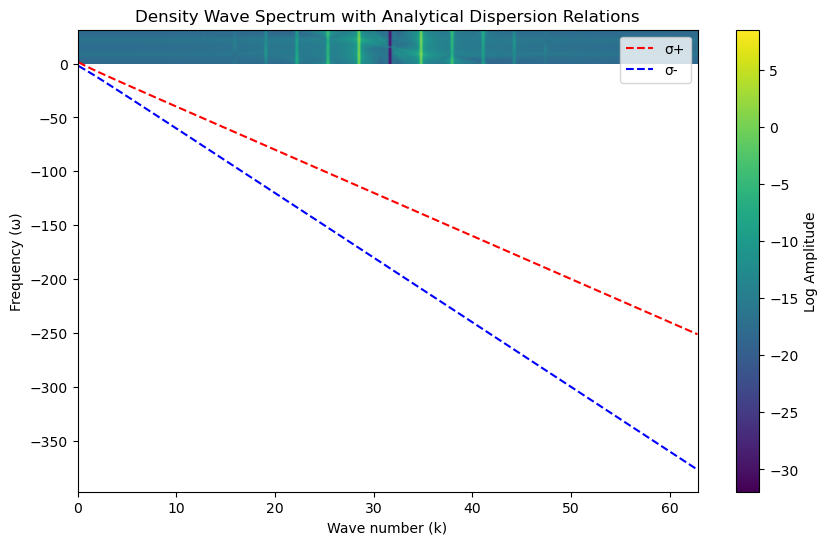

In [128]:
import numpy as np
import matplotlib.pyplot as plt

# Dummy data: Centralized density with a sinusoidal perturbation
density = fields['Density']
centralized_density = density - np.mean(density, axis=1, keepdims=True)

# Perform 2D FFT (spatial FFT for each time slice)
k = 2 * np.pi / L * np.arange(0, nx//2 + 1)
ω = 2 * np.pi / end_time * np.arange(0, num_snaps//2 + 1)
density_fft = np.fft.fftshift(np.fft.fft2(density))

# Analytical dispersion relations
k_vals = np.linspace(0.1, max(k), 100)
σ_plus = -1j * k_vals * mean_u + 1j * np.sqrt(mean_T * (k_vals**2 + 3 * mean_Γ))
σ_minus = -1j * k_vals * mean_u - 1j * np.sqrt(mean_T * (k_vals**2 + 3 * mean_Γ))

# Plot the FFT amplitude spectrum
plt.figure(figsize=(10, 6))
plt.imshow(np.log(np.abs(density_fft)), extent=(min(k), max(k), min(ω), max(ω)), aspect='auto', origin='lower')
plt.colorbar(label='Log Amplitude')
plt.xlabel('Wave number (k)')
plt.ylabel('Frequency (ω)')

# Overlay analytical dispersion relations
plt.plot(k_vals, np.imag(σ_plus), 'r--', label='σ+')
plt.plot(k_vals, np.imag(σ_minus), 'b--', label='σ-')
plt.legend()
plt.title('Density Wave Spectrum with Analytical Dispersion Relations')
plt.show()


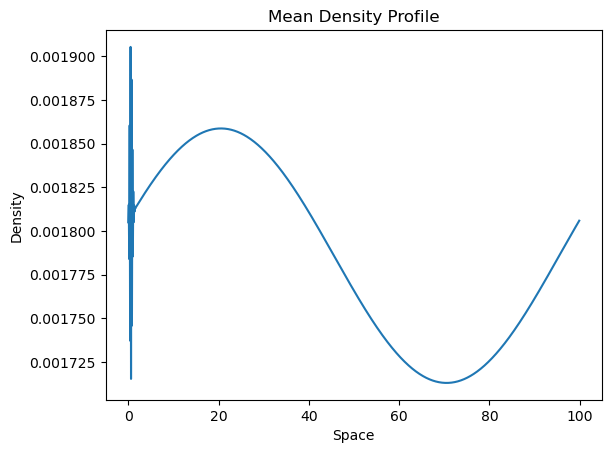

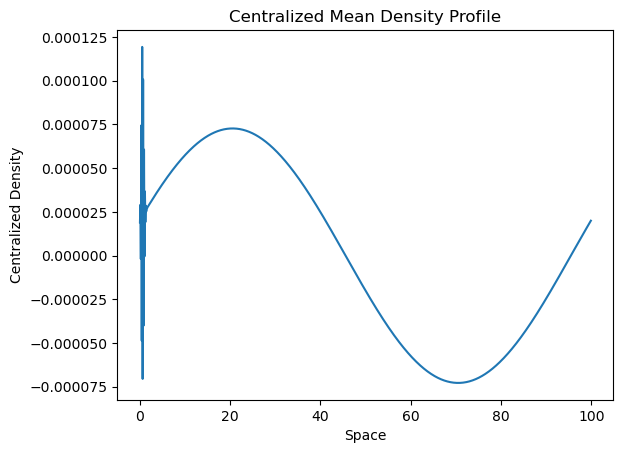

In [86]:
plt.figure()
plt.plot(X, density.mean(axis=0))  # Plot the mean density across time
plt.title('Mean Density Profile')
plt.xlabel('Space')
plt.ylabel('Density')
plt.show()

plt.figure()
plt.plot(X, centralized_density.mean(axis=0))  # Plot the mean of the centralized density across time
plt.title('Centralized Mean Density Profile')
plt.xlabel('Space')
plt.ylabel('Centralized Density')
plt.show()

### Numerical Dispersion Relation

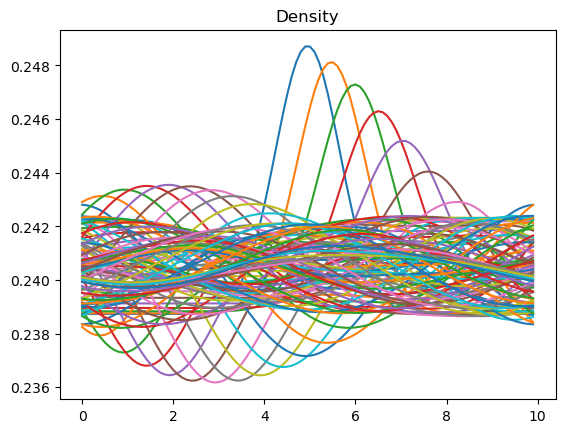

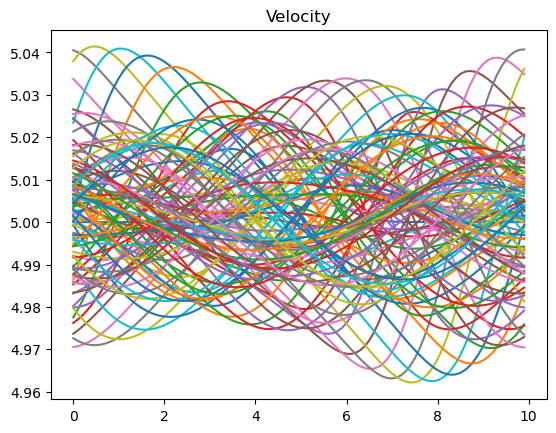

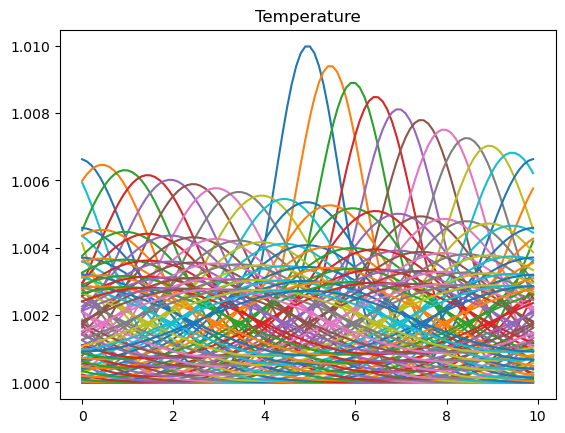

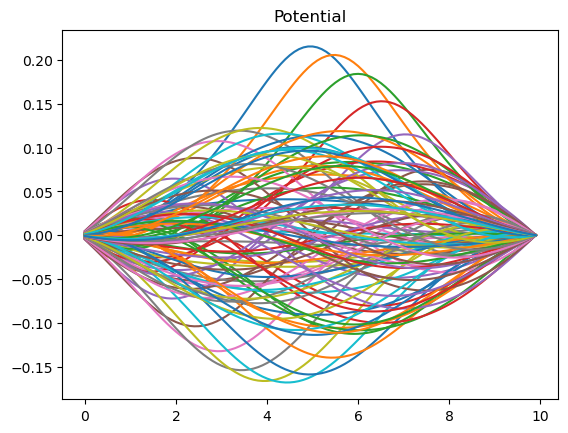

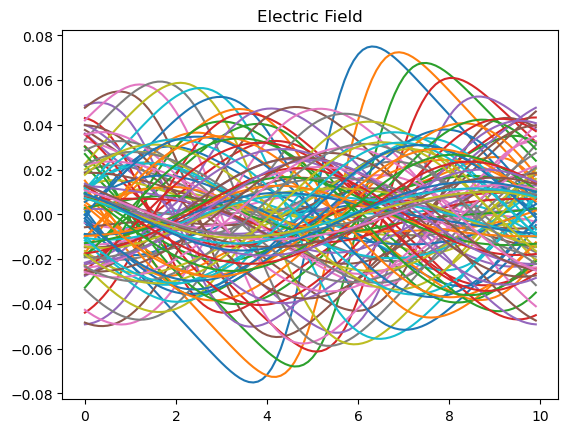

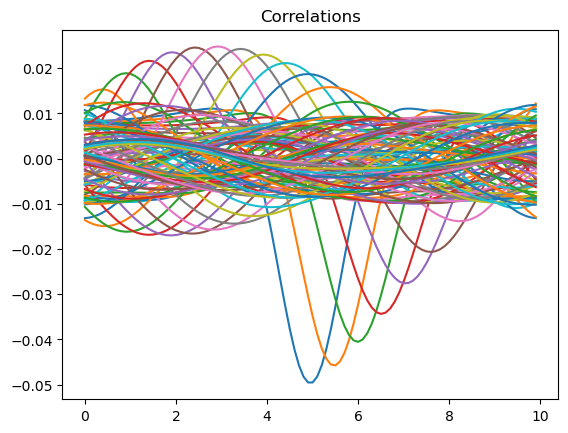

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

# Shift to Left
def l(array):
    return np.roll(array, 1, axis=-1)

# Shift to Right
def r(array):
    return np.roll(array, -1, axis=-1)

# Derivative
def ddx(array, dx):
    return (array - l(array)) / dx

# Second Derivative
def d2dx2(array, dx):
    return (r(array) - 2 * array + l(array)) / (dx * dx)

# Save Snap
def snapshot(fields, fieldConservations, n, u, T, Φ, C, cur_snap, dx, X):
    fields["Density"][cur_snap] = n
    fields["Velocity"][cur_snap] = u
    fields["Temperature"][cur_snap] = T
    fields["Potential"][cur_snap] = Φ
    fields["Electric Field"][cur_snap] = -ddx(Φ, dx)
    fields["Correlations"][cur_snap] = C

    fieldConservations["Density Integral"][cur_snap] = np.trapz(n, X)
    fieldConservations["Velocity Integral"][cur_snap] = np.trapz(u, X)
    fieldConservations["Temperature Integral"][cur_snap] = np.trapz(T, X)
    fieldConservations["Potential Sum"][cur_snap] = np.sum(Φ)
    fieldConservations["Electric Field Sum"][cur_snap] = np.sum(-ddx(Φ, dx))
    fieldConservations["Electric Field Integral"][cur_snap] = np.trapz(-ddx(Φ, dx), X)
    fieldConservations["Correlations Sum"][cur_snap] = np.sum(C)
    fieldConservations["Correlations Integral"][cur_snap] = np.trapz(C, X)

def solve_poisson(nx, n, dx):
    """
    Solves the Poisson equation with periodic boundary conditions using a special Thomas algorithm.
    """
    mean_n = np.mean(n)
    ρ = -4 * np.pi * (n - mean_n) * dx**2

    # Step 1: Compute potential at mesh point 0
    Φ = np.zeros(nx)
    Φ[0] = np.sum((np.arange(1, nx + 1) * ρ)) / nx

    # Step 2: Compute potential at mesh point 1
    Φ[1] = ρ[0] + 2 * Φ[0]

    # Step 3: Compute remaining potentials
    for i in range(2, nx):
        Φ[i] = ρ[i - 1] + 2 * Φ[i - 1] - Φ[i - 2]

    return Φ

# def solve_correlations(C):
#     return C  # TODO: Placeholder

def solve_correlations(n, L, dx, X, κ, Γ, T):
    # Constants and mesh setup
    nx = len(X)
    C = np.zeros_like(n)
    β = 1 / T

    # Extend dimensions for interactions at different locations
    Xi_grid, Xj_grid = np.meshgrid(X, X, indexing='ij')
    ni_grid, nj_grid = np.meshgrid(n, n, indexing='ij')

    # Compute distances between points
    distance = np.abs(Xi_grid - Xj_grid)
    distance = np.minimum(distance, L - distance)

    # distance[distance < ion sphere radius] = ion sphere radius  # Fix minimum distance to ions sphere radius
    distance[distance == 0] = 1e-10  # Prevent division by zero

    # Compute Coulomb Potential: u(r)
    u = 1 / distance

    # Compute Parametrization Factor: A(κ, Γ)
    A = 1 + 1.5 * Γ * np.exp(-κ)
    
    # Compute Direct Correlation Function: c(r)
    dcf = A * (np.exp(-β * u) / A - 1)

    # Calculate Correlation Interactions by integrating j axis
    C = dx * np.sum(dcf * (ni_grid - nj_grid), axis = 1)

    return C

# Spatial Domain
nx = int(1e2)
L = 10
dx = L / nx
X = np.linspace(0, L, nx, endpoint=False)

# Temporal Domain
end_time = 10
t = 0
num_snaps = 100
snap_interval = end_time / num_snaps
cur_snap = 0

# Memory Allocation for Fields
fields = {
    "Density": np.empty((num_snaps+1, nx)),
    "Velocity": np.empty((num_snaps+1, nx)),
    "Temperature": np.empty((num_snaps+1, nx)),
    "Potential": np.empty((num_snaps+1, nx)),
    "Electric Field": np.empty((num_snaps+1, nx)),
    "Correlations": np.empty((num_snaps+1, nx))
}

# Conservation checks
fieldConservations = {
    "Density Integral": np.empty(num_snaps+1),
    "Velocity Integral": np.empty(num_snaps+1),
    "Temperature Integral": np.empty(num_snaps+1), 
    "Potential Sum": np.empty(num_snaps+1),
    "Electric Field Sum": np.empty(num_snaps+1), 
    "Electric Field Integral": np.empty(num_snaps+1),
    "Correlations Sum": np.empty(num_snaps+1),
    "Correlations Integral": np.empty(num_snaps+1)
}

def update_parameters(e, Q, n, T):
    a_i = (3 / (4 * np.pi * n))**(1/3)  # Ion Sphere Radius
    λ = np.sqrt(T / (4 * np.pi * e**2 * n))  # Debye Length

    mean_a_i = np.mean(a_i)
    mean_λ = np.mean(λ)
    mean_T = np.mean(T)

    # Calculate reference Γ and κ  # TODO: Fix such that Gamma0 and kappa0 are automatically found using means as inputs and, Gamma and kappa found if not means
    Γ0 = Q**2 / (mean_a_i * mean_T)
    κ0 = mean_a_i / mean_λ

    # Update Γ and κ as fields
    Γ = Γ0 * (mean_a_i * mean_T) / (a_i * T)
    κ = κ0 * (a_i * mean_λ) / (mean_a_i * λ)
    return a_i, λ, Γ, κ

# Constants
cfl_safety = 0.1
e = 1.0  # Assuming unit charge
Q = 1.0  # Assuming unit charge
therm_cond = 0.1  # Thermal Conductivity, Technically Thermal Diffusivity After Nondimensionalization

mean_n = 3 / (4*np.pi)
mean_u = 5
mean_T = 1
a_i, λ, Γ, κ = update_parameters(e, Q, mean_n, mean_T)  # Initialize Parameters with Mean Field Values

# Initial Conditions
n = mean_n + 0.01 * np.exp(-(X - np.mean(X))**2)
u = mean_u + 0.01 * np.exp(-(X - np.mean(X))**2)
T = mean_T + 0.01 * np.exp(-(X - np.mean(X))**2)
Φ = solve_poisson(nx, n, dx)
C = solve_correlations(n, L, dx, X, κ, Γ, T)

# Save Initial Snapshot
snapshot(fields, fieldConservations, n, u, T, Φ, C, cur_snap, dx, X)
cur_snap += 1

# Time Integration
while t < end_time:
    # Calculate dt and next snapshot time
    max_field_speed = np.max(np.array([np.abs(u).max()]))
    dt = cfl_safety * dx / max_field_speed

    next_snap_time = cur_snap * snap_interval
    if t + dt >= next_snap_time:
        dt = next_snap_time - t  # Adjust dt to exactly reach the snapshot time

    # Update fields
    a_i, λ, Γ, κ = update_parameters(e, Q, n, T)
    Φ = solve_poisson(nx, n, dx)  # Solve Poisson Equation
    C = solve_correlations(n, L, dx, X, κ, Γ, T)  # Solve Correlations Equation
    n -= dt * ddx(n * u, dx)
    u -= dt * ( u * ddx(u, dx) - T * ddx(n, dx) / n + Γ * T * ddx(Φ, dx) - ddx(C, dx) )  # Subtract Correlations Term: -ddx(C) in the parenthesis
    T -= dt * ( u * ddx(T, dx) - d2dx2(therm_cond * T, dx) )

    # Time update
    t += dt

    if t >= next_snap_time:
        snapshot(fields, fieldConservations, n, u, T, Φ, C, cur_snap, dx, X)
        cur_snap += 1

# Plotting
for fieldName, fieldValues in fields.items():
    plt.figure()
    for snap in fieldValues:
        plt.plot(X, snap)
    plt.title(fieldName)
    plt.show()

# TODO: Fix derivative calculation
# TODO: Correlation domain extension
# TODO: Types of analysis? DMD, Wavelet, FFT, etc.?

# Below is correct

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

# Shift to Left
def l(array):
    return np.roll(array, 1, axis=-1)

# Shift to Right
def r(array):
    return np.roll(array, -1, axis=-1)

# Derivative
def ddx(array, dx):
    return (array - l(array)) / dx

# Second Derivative
def d2dx2(array, dx):
    return (r(array) - 2 * array + l(array)) / (dx * dx)

# Check Validity
def force_valid(n, u, T):
    n = np.clip(n, 0, 1)
    u = np.clip(u, 0, np.inf)
    T = np.clip(T, 0, np.inf)
    return n, u, T

# Save Snap
def snapshot(fields, fieldConservations, n, u, T, Φ, C, cur_snap, dx, X):
    fields["Density"][cur_snap] = n
    fields["Velocity"][cur_snap] = u
    fields["Temperature"][cur_snap] = T
    fields["Potential"][cur_snap] = Φ
    fields["Electric Field"][cur_snap] = -ddx(Φ, dx)
    fields["Correlations"][cur_snap] = C

    fieldConservations["Density Integral"][cur_snap] = np.trapz(n, X)
    fieldConservations["Velocity Integral"][cur_snap] = np.trapz(u, X)
    fieldConservations["Temperature Integral"][cur_snap] = np.trapz(T, X)
    fieldConservations["Potential Sum"][cur_snap] = np.sum(Φ)
    fieldConservations["Electric Field Sum"][cur_snap] = np.sum(-ddx(Φ, dx))
    fieldConservations["Electric Field Integral"][cur_snap] = np.trapz(-ddx(Φ, dx), X)
    fieldConservations["Correlations Sum"][cur_snap] = np.sum(C)
    fieldConservations["Correlations Integral"][cur_snap] = np.trapz(C, X)

def solve_poisson(nx, n, dx):
    """
    Solves the Poisson equation with periodic boundary conditions using a special Thomas algorithm.
    """
    mean_n = np.mean(n)
    ρ = -4 * np.pi * (n - mean_n) * dx**2

    # Step 1: Compute potential at mesh point 0
    Φ = np.zeros(nx)
    Φ[0] = np.sum((np.arange(1, nx + 1) * ρ)) / nx

    # Step 2: Compute potential at mesh point 1
    Φ[1] = ρ[0] + 2 * Φ[0]

    # Step 3: Compute remaining potentials
    for i in range(2, nx):
        Φ[i] = ρ[i - 1] + 2 * Φ[i - 1] - Φ[i - 2]

    return Φ

def solve_correlations(C):
    return C  # TODO: Placeholder

# Spatial Domain
nx = int(1e2)
L = 10
dx = L / nx
X = np.linspace(0, L, nx, endpoint=False)

# Temporal Domain
end_time = 200
t = 0
num_snaps = 1000
snap_interval = end_time / num_snaps
cur_snap = 0

# Parameters
mean_n = 3 / (4*np.pi)
Γ = 10
κ = 2
therm_cond = 0.1
cfl_safety = 0.1

# Memory Allocation for Fields
fields = {
    "Density": np.empty((num_snaps+1, nx)),
    "Velocity": np.empty((num_snaps+1, nx)),
    "Temperature": np.empty((num_snaps+1, nx)),
    "Potential": np.empty((num_snaps+1, nx)),
    "Electric Field": np.empty((num_snaps+1, nx)),
    "Correlations": np.empty((num_snaps+1, nx))
}

# Conservation checks
fieldConservations = {
    "Density Integral": np.empty(num_snaps+1),
    "Velocity Integral": np.empty(num_snaps+1),
    "Temperature Integral": np.empty(num_snaps+1), 
    "Potential Sum": np.empty(num_snaps+1),
    "Electric Field Sum": np.empty(num_snaps+1), 
    "Electric Field Integral": np.empty(num_snaps+1),
    "Correlations Sum": np.empty(num_snaps+1),
    "Correlations Integral": np.empty(num_snaps+1)
}


# Initial Conditions
n = mean_n + 0.01 * np.exp(-(X - np.mean(X))**2)
u = 5 * np.ones_like(X) + 0.01 * np.exp(-(X - np.mean(X))**2)
T = np.ones_like(X) + 0.01 * np.exp(-(X - np.mean(X))**2)
Φ = solve_poisson(nx, n, dx)
C = np.zeros_like(X)  # TODO: Add Correlations

# Save Initial Snapshot
snapshot(fields, fieldConservations, n, u, T, Φ, C, cur_snap, dx, X)
cur_snap += 1

# Time Integration
while t < end_time:
    # Calculate dt and next snapshot time
    max_field_speed = np.max(np.array([np.abs(u).max()]))
    dt = cfl_safety * dx / max_field_speed

    next_snap_time = cur_snap * snap_interval
    if t + dt >= next_snap_time:
        dt = next_snap_time - t  # Adjust dt to exactly reach the snapshot time

    # Update fields
    Φ = solve_poisson(nx, n, dx)  # Solve Poisson Equation
    C = solve_correlations(C)  # Solve Correlations Equation
    n -= dt * ddx(n * u, dx)
    u -= dt * ( u * ddx(u, dx) - T * ddx(n, dx) / n + Γ * T * ddx(Φ, dx))  # Subtract Correlations Term: -ddx(C) in the parenthesis
    T -= dt * ( u * ddx(T, dx) - d2dx2(therm_cond * T, dx) )

    # Check Validity
    n, u, T = force_valid(n, u, T)

    # Time update
    t += dt

    # Snapshot
    if t >= next_snap_time:
        snapshot(fields, fieldConservations, n, u, T, Φ, C, cur_snap, dx, X)
        cur_snap += 1

# Plotting
for fieldName, fieldValues in fields.items():
    plt.figure()
    for snap in fieldValues:
        plt.plot(X, snap)
    plt.title(fieldName)
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [79]:
# Plot Conserved Values
for fieldName, fieldValues in fieldConservations.items():
    plt.figure()
    plt.plot(np.arange(num_snaps + 1), fieldValues)
    plt.title(fieldName)
    plt.xlabel("Time")
    plt.ylabel(fieldName)
    plt.show()

# Heat Map
for fieldName, fieldValues in fields.items():
    plt.figure()
    plt.imshow(fieldValues, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.title(fieldName)
    plt.ylabel("Time (Snapshots)")
    plt.xlabel("Space (X)")
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
%matplotlib notebook
# %matplotlib widget
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

# Animation
def fieldAnimations(fieldName, fieldValues):
    fig, ax = plt.subplots()
    line, = ax.plot(X, fieldValues[0])

    def update(frame):
        validData = fieldValues[frame][np.isfinite(fieldValues[frame])]
        line.set_ydata(fieldValues[frame])
        ax.set_title(f'{fieldName} at Time = {frame * snap_interval:.2f}s')
        lowerBound = 0.999 * np.min(validData)
        upperBound = 1.001 * np.max(validData)
        ax.set_ylim(lowerBound, upperBound)
        return line,

    ani = FuncAnimation(fig, update, frames=num_snaps+1, interval=50, blit=True)
    return ani

for fieldName, fieldValues in fields.items():
    ani = fieldAnimations(fieldName, fieldValues)
    display(HTML(ani.to_jshtml()))
    # plt.close()
    # plt.show()


<IPython.core.display.Javascript object>

# HNC

Converged in 3121 iterations.


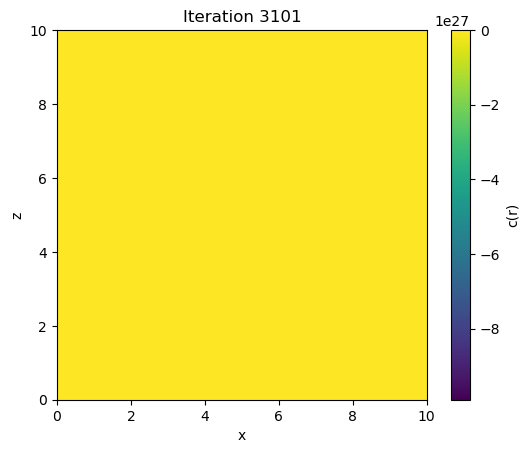

In [3]:
import numpy as np
from scipy.fftpack import fftn, ifftn
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from PIL import Image

# Define parameters
L = 10.0  # Box length
original_nx = 100
new_nx = 16  # New number of grid points
ny, nz = new_nx, new_nx  # Number of grid points in y and z directions
dy, dz = L / ny, L / nz  # Grid spacing in y and z directions

# Original x grid and new x grid
x_original = np.linspace(0, L, original_nx, endpoint=False)
x_new = np.linspace(0, L, new_nx, endpoint=False)

# Assume n(x) and T(x) are defined elsewhere as 1D arrays with 100 points
# Example:
# n = np.random.rand(original_nx)
# T = np.random.rand(original_nx) * 300 + 10

# Interpolate n(x) and T(x) to new grid
n_interpolator = interp1d(x_original, n, kind='cubic')
T_interpolator = interp1d(x_original, T, kind='cubic')
n_new = n_interpolator(x_new)
T_new = T_interpolator(x_new)

# Create the new 3D grid
x = np.linspace(0, L, new_nx, endpoint=False)
y = np.linspace(0, L, ny, endpoint=False)
z = np.linspace(0, L, nz, endpoint=False)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Extend n_new and T_new to 3D
n = np.tile(n_new[:, np.newaxis, np.newaxis], (1, ny, nz))
T = np.tile(T_new[:, np.newaxis, np.newaxis], (1, ny, nz))
β = 1 / T  # Inverse temperature

# Interaction potential (e.g., Lennard-Jones potential)
def lennard_jones(r, epsilon=1.0, σ=1.0):
    r = np.maximum(r, 1e-10)  # Avoid singularity at r = 0
    r6 = (σ / r)**6
    r12 = r6 * r6
    return 4 * epsilon * (r12 - r6)

# Compute the distance matrix
r = np.sqrt(X**2 + Y**2 + Z**2)
φ = lennard_jones(r)

# Initialize h and c
h = np.zeros((new_nx, ny, nz))
c = np.zeros((new_nx, ny, nz))

# Solve the HNC equations iteratively
max_iter = 10000
tol = 1e-5
damping_factor = 0.25  # Damping factor to aid convergence

# Create a figure for the plot
fig, ax = plt.subplots()
cax = ax.imshow(c[:, ny//2, :], extent=(0, L, 0, L))
cbar = fig.colorbar(cax, label='c(r)')
ax.set_title('Direct Correlation Function')
ax.set_xlabel('x')
ax.set_ylabel('z')

# List to store frames for the animation
frames = []

for iter in range(max_iter):
    h_old = h.copy()
    
    # Compute the Fourier transforms
    h_k = fftn(h)
    c_k = fftn(c)
    
    # Solve the OZ equation in Fourier space
    denominator = 1 - n * c_k
    denominator[denominator == 0] = 1e-10  # Avoid division by zero
    h_k = c_k / denominator
    h = np.real(ifftn(h_k))
    
    # Solve the HNC closure relation
    argument = -β * φ + h - c
    argument = np.clip(argument, -100, 100)  # Clip to prevent overflow
    h_new = np.exp(argument) - 1
    
    # Damping step
    h = damping_factor * h_new + (1 - damping_factor) * h_old
    
    # Update c using the OZ relation
    c = h - np.exp(argument) + 1
    
    # Check for convergence
    error = np.linalg.norm(h - h_old)
    if error < tol:
        print(f"Converged in {iter+1} iterations.")
        break

    # Save every 25th frame
    if iter % 25 == 0:
        # Update plot
        cax.set_data(c[:, ny//2, :])
        cax.set_clim(np.min(c), np.max(c))
        ax.set_title(f'Iteration {iter+1}')
        
        # Draw the plot and convert to image
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frames.append(Image.fromarray(image))

# Save the animation as GIF
if frames:
    frames[0].save('correlation_convergence.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)

plt.show()

# For future Poisson fix

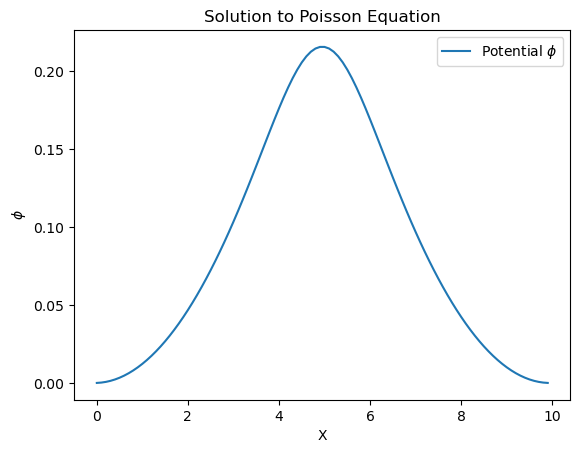

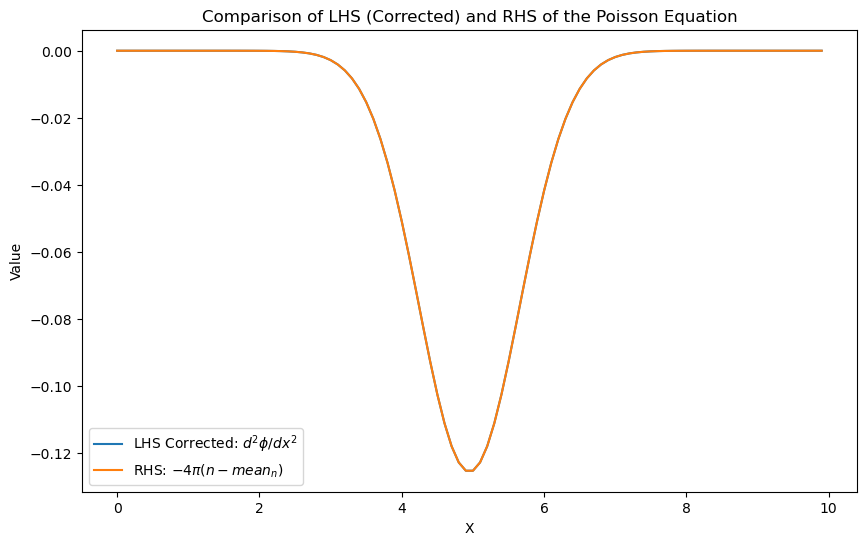

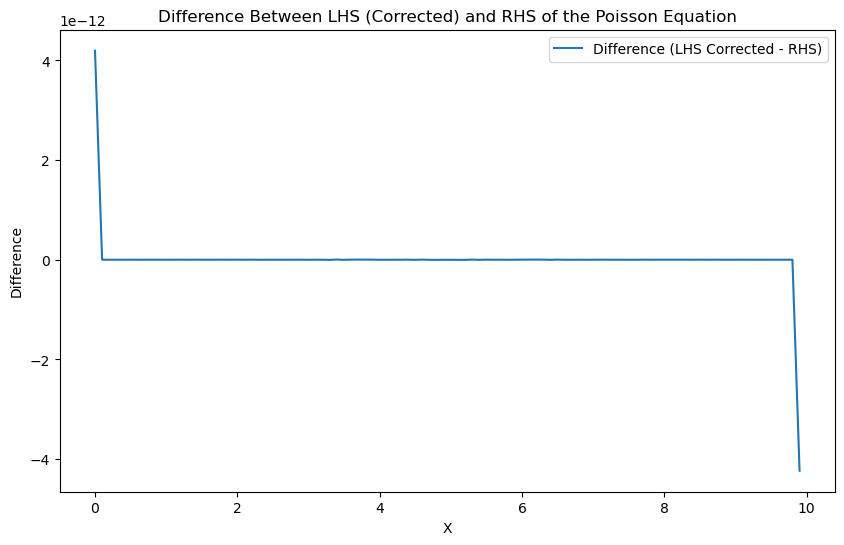

Test Case 1: Mean Difference = 1.806543e-18, Std Difference = 5.960287e-13, Max Difference = 4.234216e-12


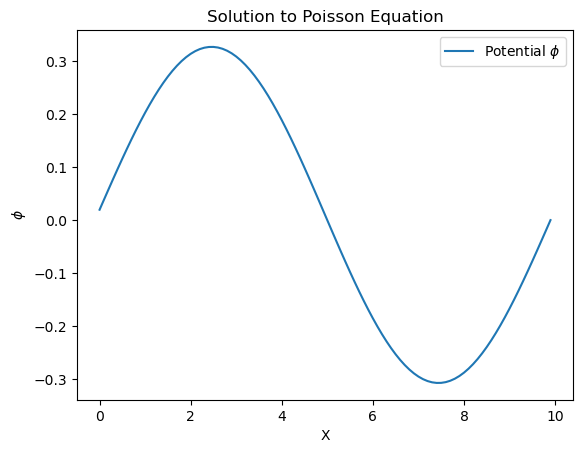

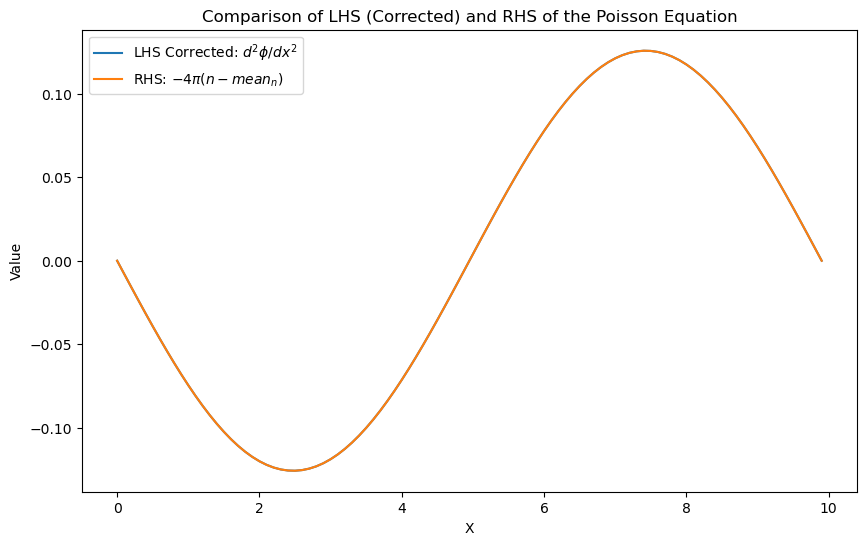

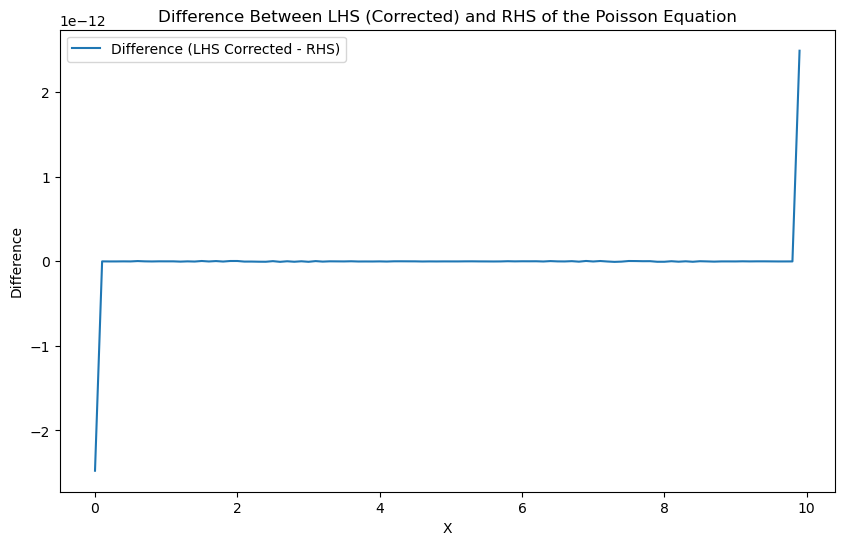

Test Case 2: Mean Difference = 2.081668e-18, Std Difference = 3.512438e-13, Max Difference = 2.491406e-12


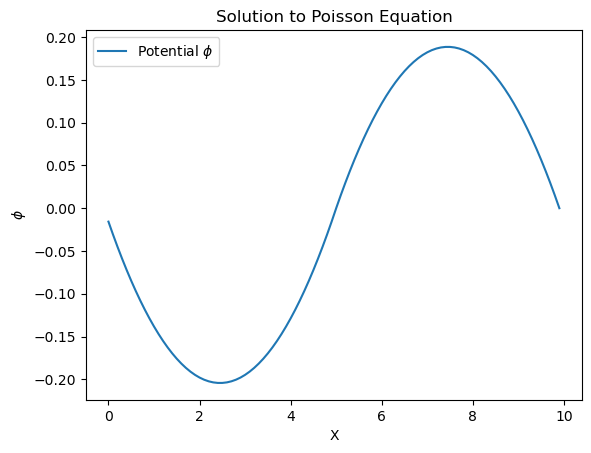

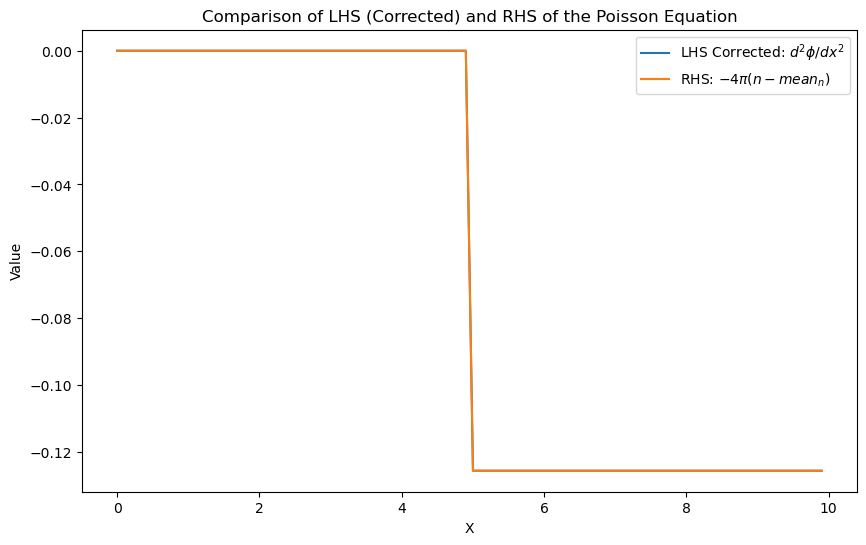

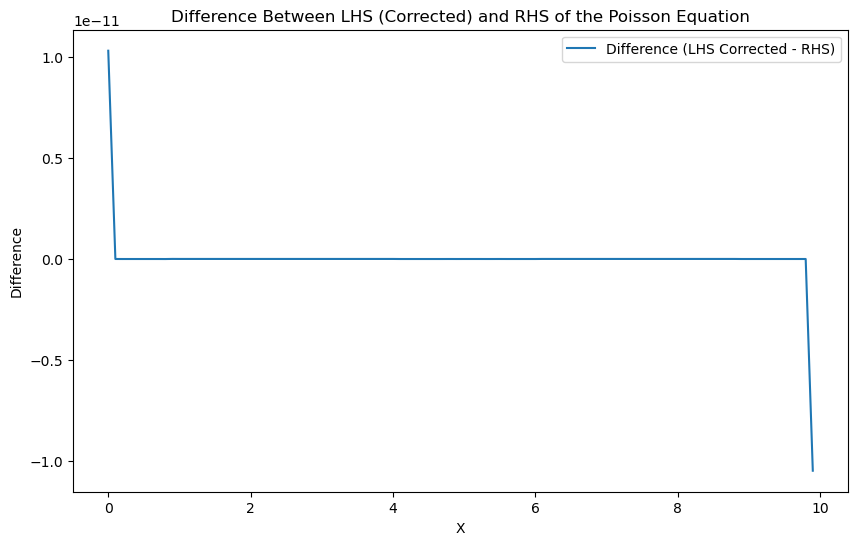

Test Case 3: Mean Difference = -1.693090e-17, Std Difference = 1.471190e-12, Max Difference = 1.048772e-11


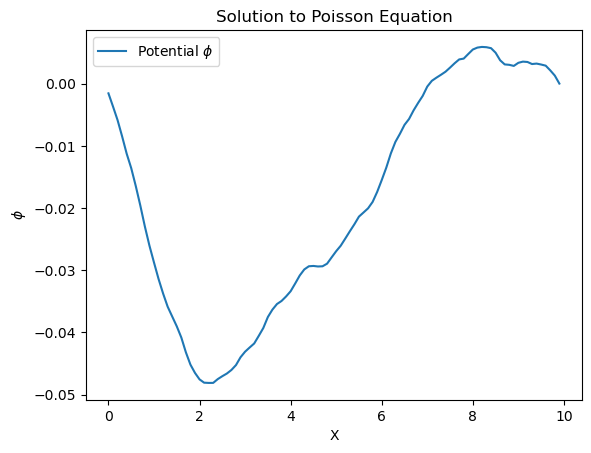

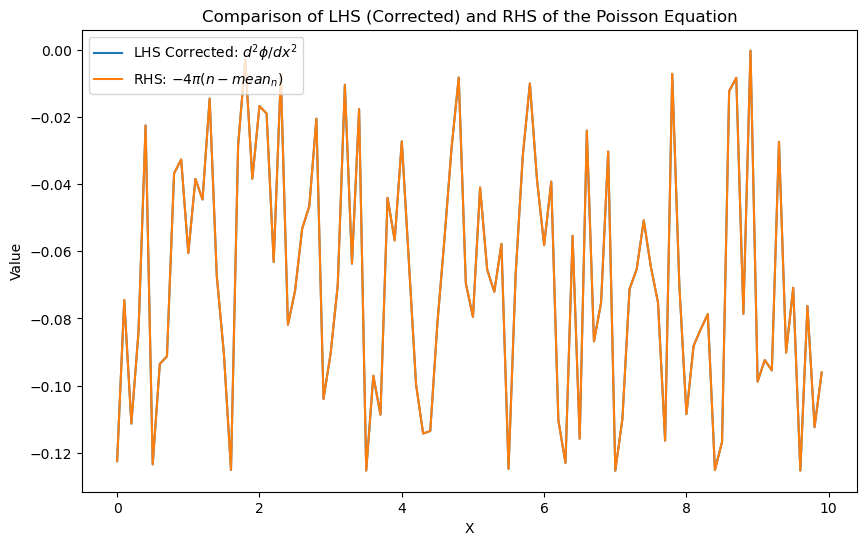

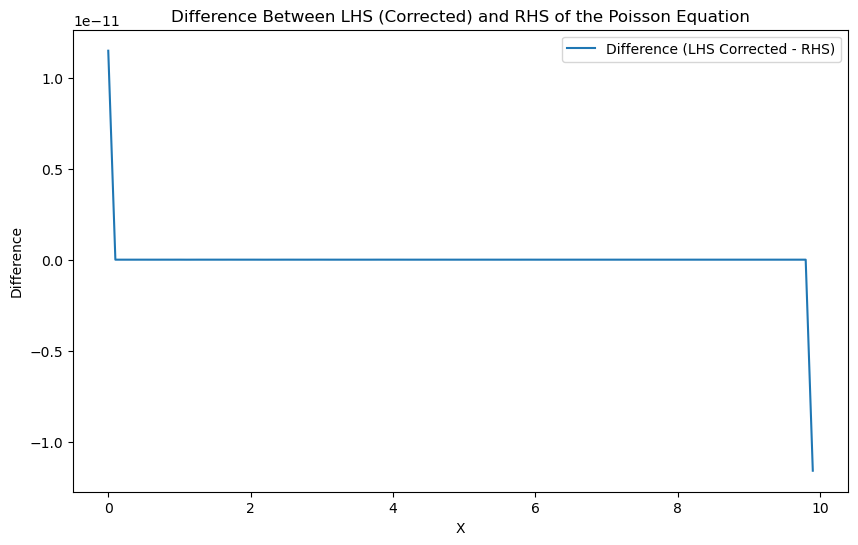

Test Case 4: Mean Difference = -3.079134e-19, Std Difference = 1.631208e-12, Max Difference = 1.159077e-11


[(1.8065426861635327e-18, 5.9602874227474e-13, 4.234216067057161e-12),
 (2.0816681711721684e-18, 3.512438271053205e-13, 2.491406386750938e-12),
 (-1.6930901125533637e-17, 1.4711902808642336e-12, 1.0487721802121541e-11),
 (-3.0791341698588324e-19, 1.6312077091407104e-12, 1.1590770010450058e-11)]

In [125]:
import numpy as np
import matplotlib.pyplot as plt

def solve_poisson(nx, n, dx):
    """
    Solves the Poisson equation with periodic boundary conditions using a special Thomas algorithm.
    """
    mean_n = np.mean(n)
    ρ = -4 * np.pi * (n - mean_n) * dx**2

    # Step 1: Compute potential at mesh point 0
    Φ = np.zeros(nx)
    Φ[0] = np.sum((np.arange(1, nx + 1) * ρ)) / nx

    # Step 2: Compute potential at mesh point 1
    Φ[1] = ρ[0] + 2 * Φ[0]

    # Step 3: Compute remaining potentials
    for i in range(2, nx):
        Φ[i] = ρ[i - 1] + 2 * Φ[i - 1] - Φ[i - 2]

    return Φ

def run_test_case(nx, L, n_func):
    dx = L / nx
    X = np.linspace(0, L, nx, endpoint=False)
    mean_n = 3 / (4 * np.pi)
    n = n_func(X, mean_n)

    # Solve for Φ
    Φ = solve_poisson(nx, n, dx)

    # Verify the solution by plugging it back into the Poisson equation
    lhs = (np.roll(Φ, -1) - 2 * Φ + np.roll(Φ, 1)) / (dx * dx)
    rhs = -4 * np.pi * (n - mean_n)

    # Calculate the vertical translation (offset) between lhs and rhs
    offset = lhs - rhs
    mean_offset = np.mean(offset)

    # Correct the lhs by subtracting the mean offset
    lhs_corrected = lhs - mean_offset

    # Calculate the difference between lhs_corrected and rhs
    difference = lhs_corrected - rhs
    mean_difference = np.mean(difference)
    std_difference = np.std(difference)
    max_difference = np.max(np.abs(difference))

    # Plot the results
    plt.figure()
    plt.plot(X, Φ, label="Potential $\phi$")
    plt.title("Solution to Poisson Equation")
    plt.xlabel("X")
    plt.ylabel("$\phi$")
    plt.legend()
    plt.show()

    # Plot to compare the LHS and RHS
    plt.figure(figsize=(10, 6))
    plt.plot(X, lhs_corrected, label="LHS Corrected: $d^2 \phi / dx^2$")
    plt.plot(X, rhs, label="RHS: $-4 \pi (n - mean_n)$")
    plt.title("Comparison of LHS (Corrected) and RHS of the Poisson Equation")
    plt.xlabel("X")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    # Plot the difference
    plt.figure(figsize=(10, 6))
    plt.plot(X, difference, label="Difference (LHS Corrected - RHS)")
    plt.title("Difference Between LHS (Corrected) and RHS of the Poisson Equation")
    plt.xlabel("X")
    plt.ylabel("Difference")
    plt.legend()
    plt.show()

    return mean_difference, std_difference, max_difference

# Test cases
def n_func_gaussian(X, mean_n):
    return mean_n + 0.01 * np.exp(-(X - np.mean(X))**2)

def n_func_sine(X, mean_n):
    return mean_n + 0.01 * np.sin(2 * np.pi * X / X.max())

def n_func_step(X, mean_n):
    return mean_n + 0.01 * (X > X.mean()).astype(float)

def n_func_random(X, mean_n):
    return mean_n + 0.01 * np.random.rand(len(X))

test_cases = [n_func_gaussian, n_func_sine, n_func_step, n_func_random]
nx = 100
L = 10

results = []
for i, n_func in enumerate(test_cases):
    mean_diff, std_diff, max_diff = run_test_case(nx, L, n_func)
    results.append((mean_diff, std_diff, max_diff))
    print(f"Test Case {i+1}: Mean Difference = {mean_diff:.6e}, Std Difference = {std_diff:.6e}, Max Difference = {max_diff:.6e}")

results

# Change to Solve IVP

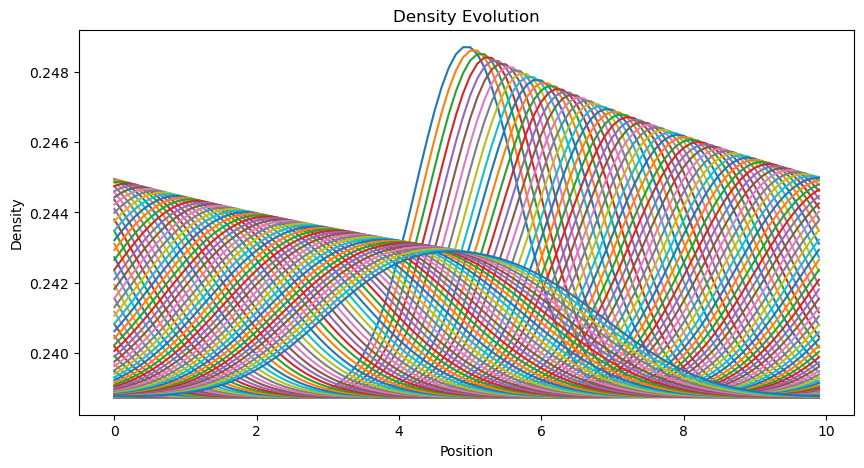

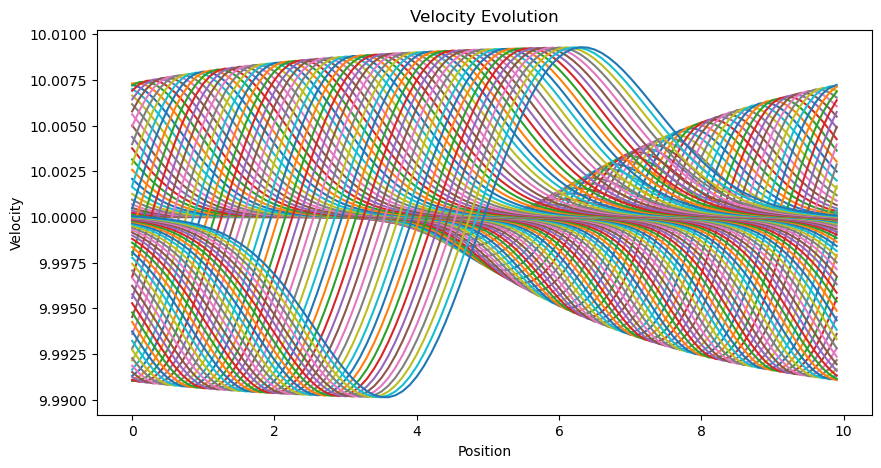

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Spatial domain setup
nx = int(1e2)
L = 10
dx = L / nx
X = np.linspace(0, L, nx, endpoint=False)

# Temporal domain setup
end_time = 1.0
num_snaps = 100

# Physics parameters
mean_n = 3 / (4 * np.pi)

# Initial conditions
initial_n = mean_n + 0.01 * np.exp(-(X - np.mean(X)) ** 2)  # Gaussian
initial_u = 10 * np.ones_like(X)
initial_T = np.ones_like(X)
initial_Φ = np.zeros_like(X)

# Combine initial conditions into a single array
initial_conditions = np.concatenate([initial_n, initial_u, initial_T, initial_Φ])

def system_of_equations(t, y):
    # Extract fields from the flattened array
    n = y[:nx]
    u = y[nx:2*nx]
    T = y[2*nx:3*nx]
    Φ = y[3*nx:4*nx]

    # Calculate derivatives
    dn_dt = -ddx(n * u, dx)
    du_dt = -u * ddx(u, dx) - T * ddx(n, dx) / n
    dT_dt = np.zeros_like(n)  # Placeholder for temperature evolution
    dΦ_dt = np.zeros_like(n)  # Placeholder for potential evolution

    # Return flattened derivative array
    return np.concatenate([dn_dt, du_dt, dT_dt, dΦ_dt])

# Use a stiff solver with a smaller maximum step size
solution = solve_ivp(
    system_of_equations, 
    [0, end_time], 
    initial_conditions, 
    t_eval=np.linspace(0, end_time, num_snaps+1),
    method='Radau',  # This is more suitable for stiff systems
    max_step=.5e-1     # Control the maximum step size to ensure stability
)

# Extract fields from solution
n_solutions = solution.y[:nx, :]
u_solutions = solution.y[nx:2*nx, :]
T_solutions = solution.y[2*nx:3*nx, :]
Φ_solutions = solution.y[3*nx:4*nx, :]

# Plotting - example for Density
plt.figure(figsize=(10, 5))
for i in range(n_solutions.shape[1]):
    plt.plot(X, n_solutions[:, i], label=f'Time = {solution.t[i]:.2f}s')
plt.title('Density Evolution')
plt.xlabel('Position')
plt.ylabel('Density')
# plt.legend()
plt.show()

# Plotting - example for Density
plt.figure(figsize=(10, 5))
for i in range(u_solutions.shape[1]):
    plt.plot(X, u_solutions[:, i], label=f'Time = {solution.t[i]:.2f}s')
plt.title('Velocity Evolution')
plt.xlabel('Position')
plt.ylabel('Velocity')
# plt.legend()
plt.show()

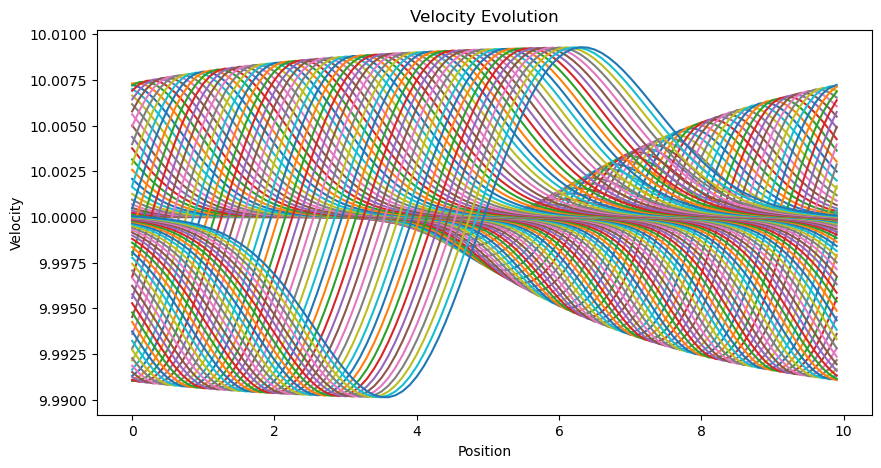

In [100]:
# Plotting - example for Density
plt.figure(figsize=(10, 5))
for i in range(u_solutions.shape[1]):
    plt.plot(X, u_solutions[:, i], label=f'Time = {solution.t[i]:.2f}s')
plt.title('Velocity Evolution')
plt.xlabel('Position')
plt.ylabel('Velocity')
# plt.legend()
plt.show()

/var/folders/mj/vl8lzxz54kq5ykc7s_pzj2980000gn/T/ipykernel_47093/1159282412.py:16: RuntimeWarning: overflow encountered in divide
  return (r(array) - l(array)) / (2 * dx)
/var/folders/mj/vl8lzxz54kq5ykc7s_pzj2980000gn/T/ipykernel_47093/1159282412.py:88: RuntimeWarning: invalid value encountered in divide
  u -= dt * u * ddx(u, dx) - T * ddx(n, dx) / n


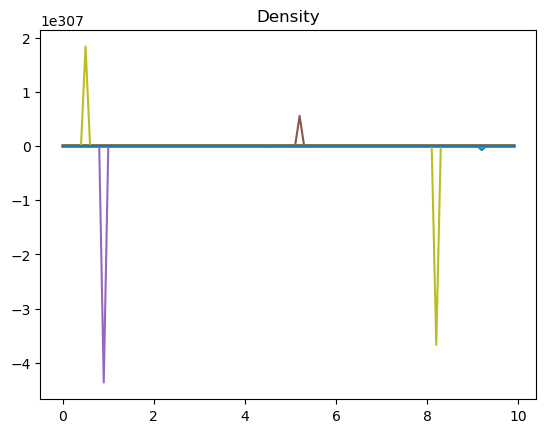

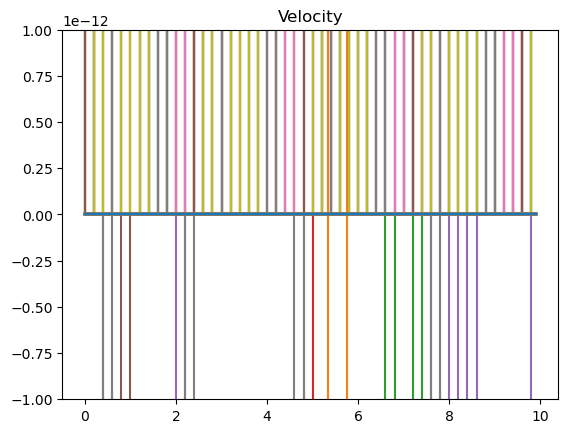

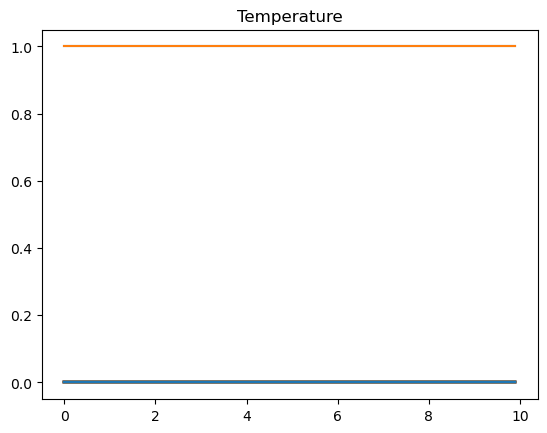

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 640x480 with 1 Axes>